# Methow Boxplots

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
from rasterstats import zonal_stats
import hvplot.pandas
import pickle
from scipy import stats
from scipy.signal import savgol_filter
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
def nmad(df):
    return scipy.stats.median_abs_deviation(df, nan_policy='omit', scale='normal')

def p16(df):
    return np.nanpercentile(df, 16)

def p84(df):
    return np.nanpercentile(df, 84)

def spread(df):
    return p84(df) - p16(df)

In [7]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [8]:
#map_tiles = EsriImagery()
#map_tiles = StamenTerrain()
map_tiles = gvts.StamenTerrain

In [9]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [10]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [11]:
mpl_epoch = '1970-01-01'

In [12]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

### Load in the saved data:

In [14]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks/figure_production


In [16]:
atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

snwd = pickle.load(open('../../data/snotel/snotel_snwd_35.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/snotel/snotel_geometries.pkl', 'rb'))

In [18]:
import myfunctions
from myfunctions import boxplot_date_aso_all

In [19]:
snow_columns = ['tum_m', 'dan_clean']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


NameError: name 'dt_min_plot' is not defined

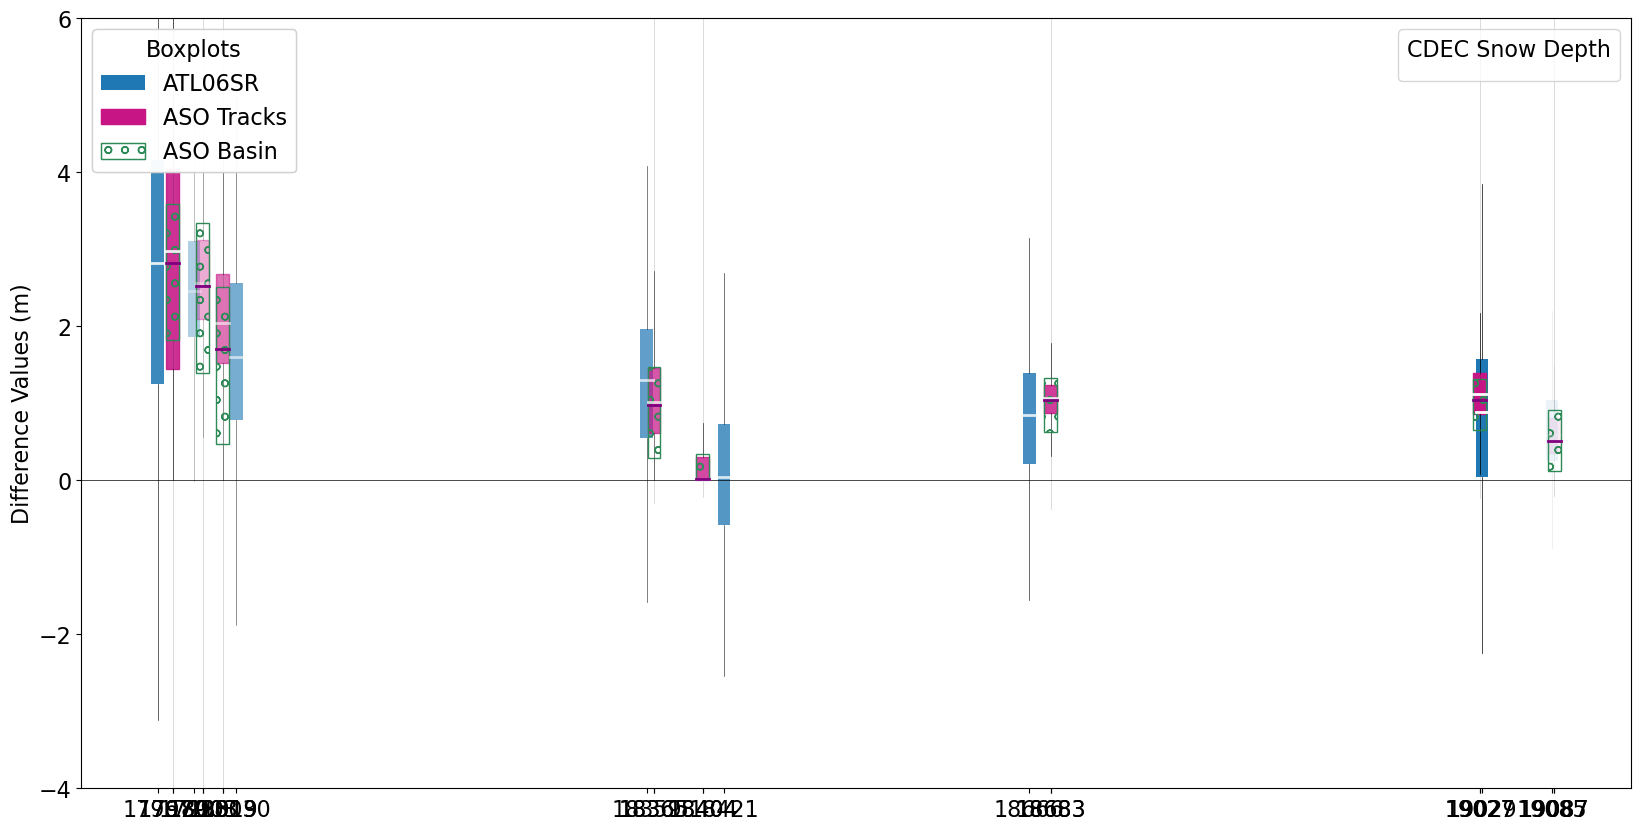

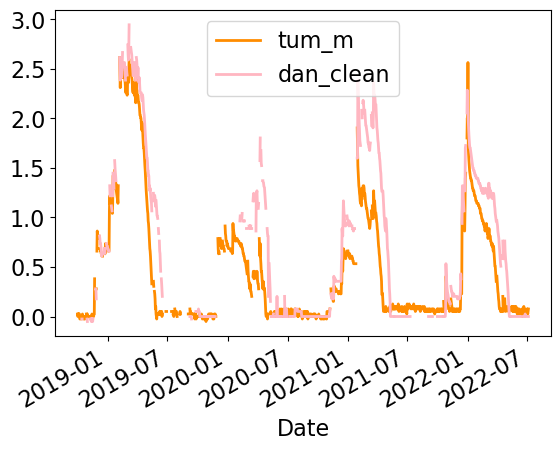

In [20]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', snow_df=snwd, snow_columns=snow_columns, region_aso=outline_gdf, rasterstats=True, snowon_list=aso_fn_winters, clim=(-4,6))

## Create Transparent Boxplots

Playing with parameters to see how each piece works:

In [17]:
bp_stats = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').apply(cbook.boxplot_stats)
bp_stats_list = [i[0] for i in bp_stats.values]
bp_alpha = atl06sr_gdf[['diff_plus', 'acqdate']].dropna().groupby('acqdate').count().values.ravel()
bp_alpha_boxes = bp_alpha/bp_alpha.max()
pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values

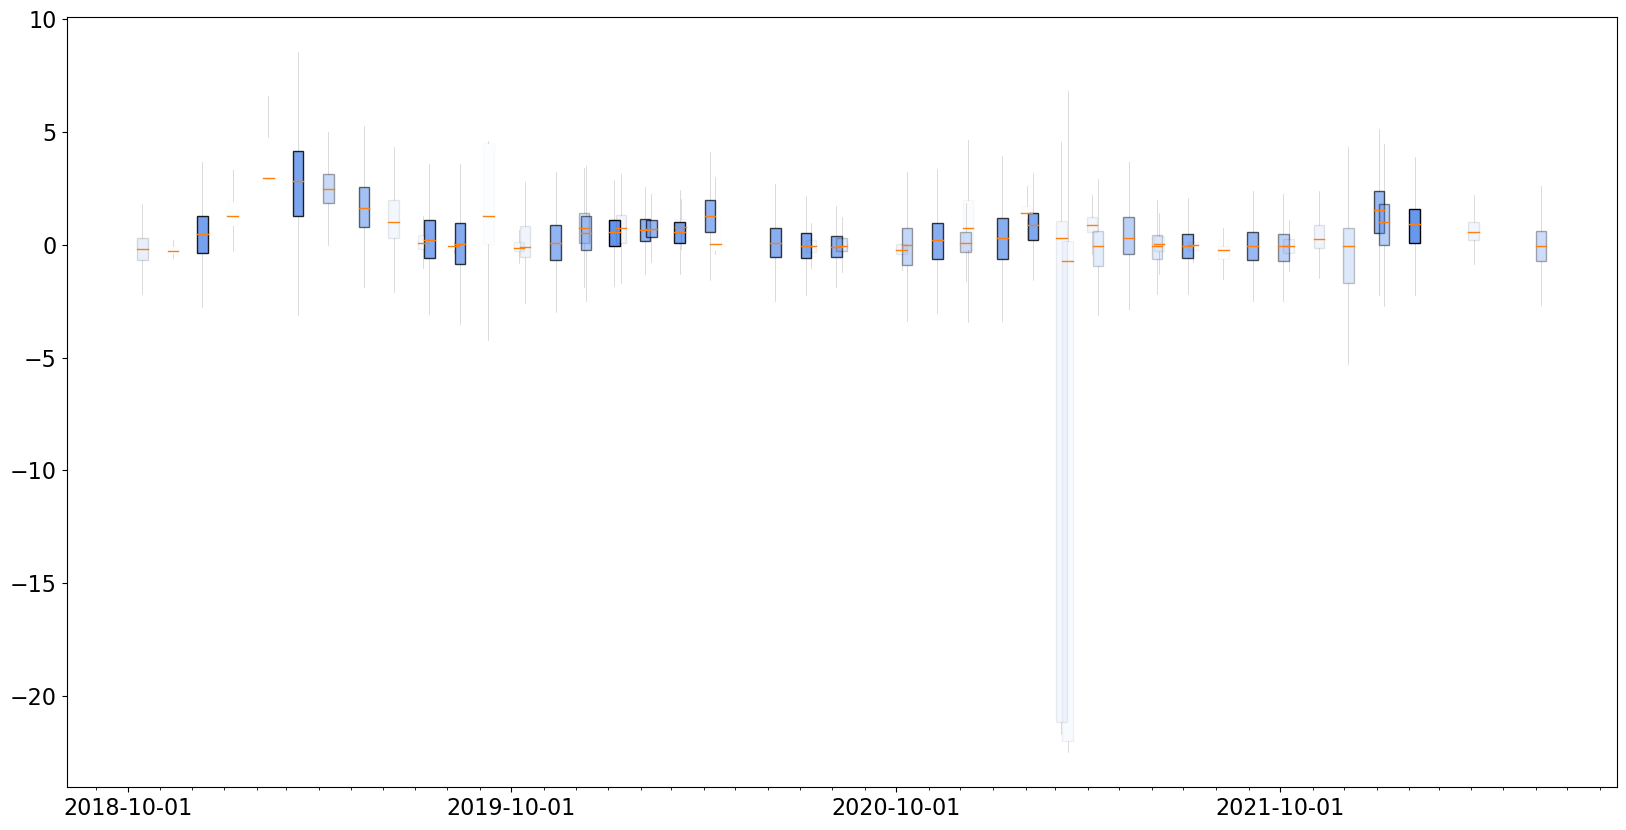

In [18]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'

f, ax = plt.subplots(figsize=(20,10))
bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, whiskerprops={'lw':0.5, 'alpha':0.2}, widths=10, patch_artist=True)

for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
    patch.set_alpha(alpha)
    patch.set_facecolor('cornflowerblue')

years = mdates.YearLocator(month=10)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
years_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
months = mdates.MonthLocator()
ax.xaxis.set_minor_locator(months)

### Transparent Boxplots with CDEC and ATL06SR Data

In [21]:
snwd

,SNOTEL:1259_WA_SNTL,SNOTEL:728_WA_SNTL,doy,decyear,dowy
datetime,,,,,
2018-10-03 00:00:00+00:00,0.0,0.0000,276,2018.753425,3
2018-10-04 00:00:00+00:00,0.0,0.0000,277,2018.756164,4
2018-10-05 00:00:00+00:00,0.0,0.0000,278,2018.758904,5
2018-10-06 00:00:00+00:00,0.0,0.0000,279,2018.761644,6
2018-10-07 00:00:00+00:00,0.0,0.0000,280,2018.764384,7
...,...,...,...,...,...
2022-10-14 00:00:00+00:00,NaN,0.0000,287,2022.783562,14
2022-10-15 00:00:00+00:00,NaN,0.0000,288,2022.786301,15
2022-10-16 00:00:00+00:00,NaN,0.0000,289,2022.789041,16


In [39]:
# Function adapted from David Shean by Hannah Besso
# Uses boxplot transparency to indicate sample size

def boxplot_date_aso_all(df, col, col_aso=None, rasterstats=False, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', region_aso=outline_gdf, 
                         title='Difference w Offset', name='boxplots', clim=(-2, 5)):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats tracks
    if col_aso != None:
        bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
        bp_stats_list2 = [i[0] for i in bp_stats2.values]
        bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
        bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
        pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values 
    
    # ASO Snow-On Stats whole region
    if rasterstats:
        stats_dict = build_bp_stats(aso_fn_winters, region_aso)
        bp_alpha_boxes3 = stats_dict[2]/stats_dict[2].max()
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['SNOTEL:1259_WA_SNTL'].plot(alpha=1, color='darkorange', lw=2, label='Muckamuck')
    snwd['SNOTEL:728_WA_SNTL'].plot(alpha=1, color='lightpink', lw=2, label='Salmon Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3},widths=10, patch_artist=True)
    # Plot ASO snow on data
    if col_aso != None:
        bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, 
                    whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10, patch_artist=True)
    if rasterstats:
        bxp_f3 = ax.bxp(stats_dict[0], positions=stats_dict[1], showfliers=False, showcaps=False, 
                        whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1, 'alpha':1}, 
                        medianprops={'lw':3, 'color':'purple'}, widths=10, patch_artist=True)
    
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_color('mediumvioletred')
    if rasterstats:
        for patch, alpha in zip(bxp_f3['boxes'], bp_alpha_boxes3):
            patch.set_facecolor('grey')
            patch.set_edgecolor('none')
            patch.set_alpha(alpha)
            #patch.set_hatch('o')
    
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='SNOTEL Snow Depth')
    legend1.set_alpha(1)
    if rasterstats:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0], bxp_f3['boxes'][0]], ['ATL06SR', 'ASO Tracks', 'ASO Basin'], loc='upper left', title='Boxplots')
    elif col_aso != None:
        legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots') 
    else:
        legend2 = ax.legend([bxp_f['boxes'][0]], ['ATL06SR'], loc='upper left', title='Boxplots')
    ax.add_artist(legend1)
    ax.add_artist(legend2)
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_edgecolor('None')
        patch.set_linewidth(0)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On tracks alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    if col_aso != None:
        for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
            patch.set_alpha(alpha)    
        for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
            patch.set_alpha(alpha)
            patch.set_color('white')  # or deeppink
        #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
        for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
            patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title) 
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
#     months = mdates.MonthLocator()
#     ax.format_xdata = mdates.DateFormatter('%m')
#     months_fmt = mdates.DateFormatter('%m')
#     ax.xaxis.set_major_locator(months)
#     ax.xaxis.set_major_formatter(months_fmt)
    
    plt.tight_layout()
    plt.savefig(f'../../figures/polished/{name}.jpeg', dpi=500)

In [35]:
pwd

'/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_methow/notebooks/figure_production'

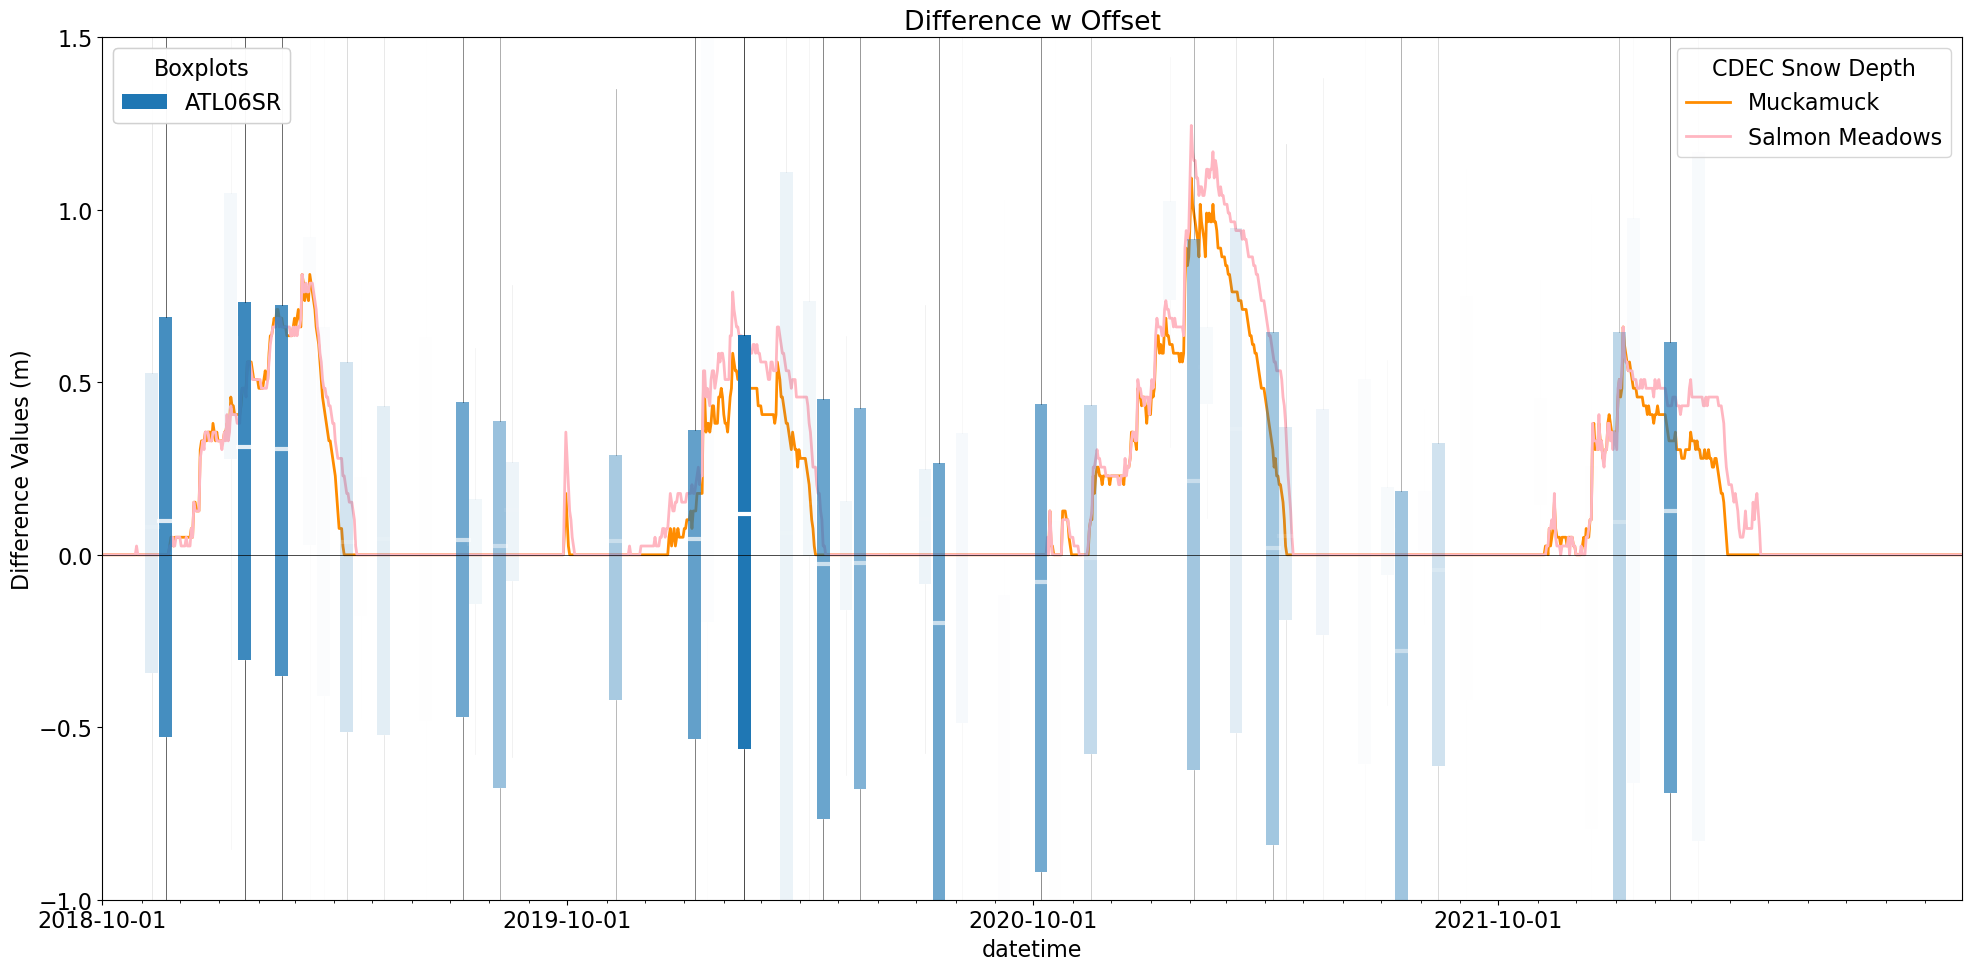

In [37]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', clim=(-1,1.5), name='boxplots_diffplus')

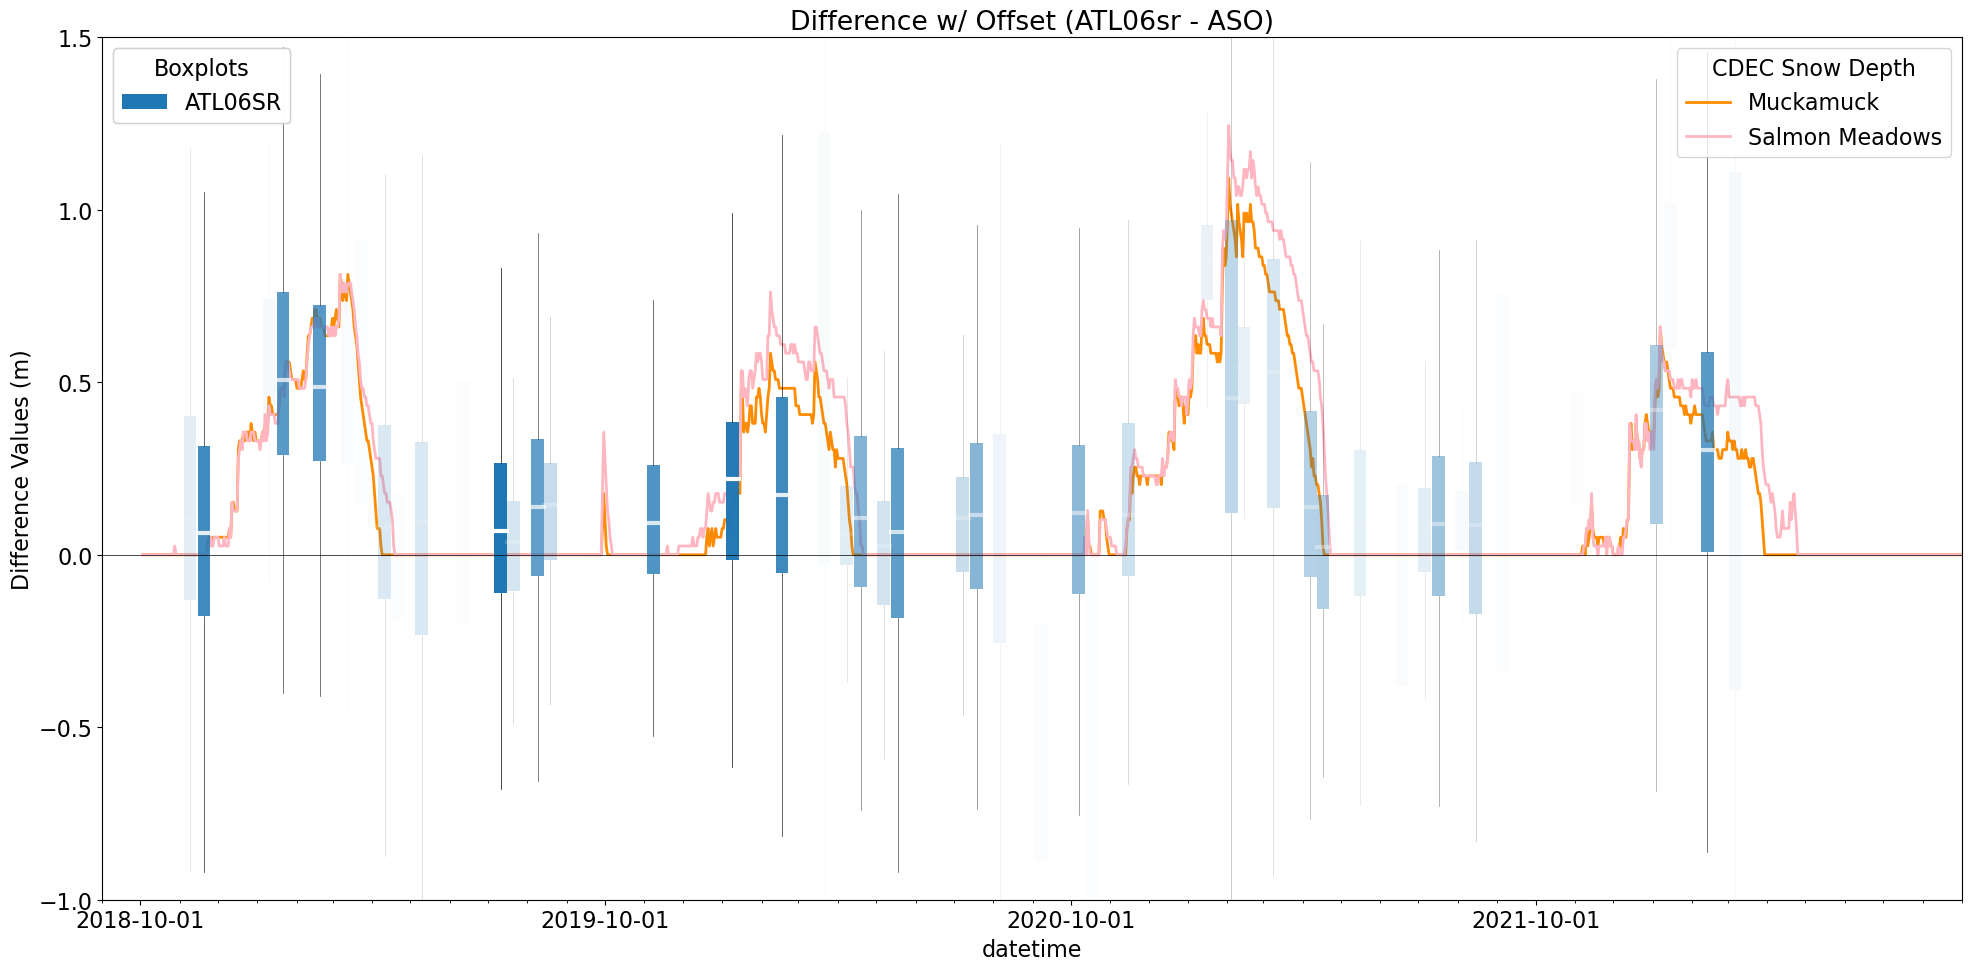

In [38]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m']<10], 'diff_plus', clim=(-1,1.5), title = 'Difference w/ Offset (ATL06sr - ASO)', name = 'boxplots_diffplus_slope10')

In [183]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks


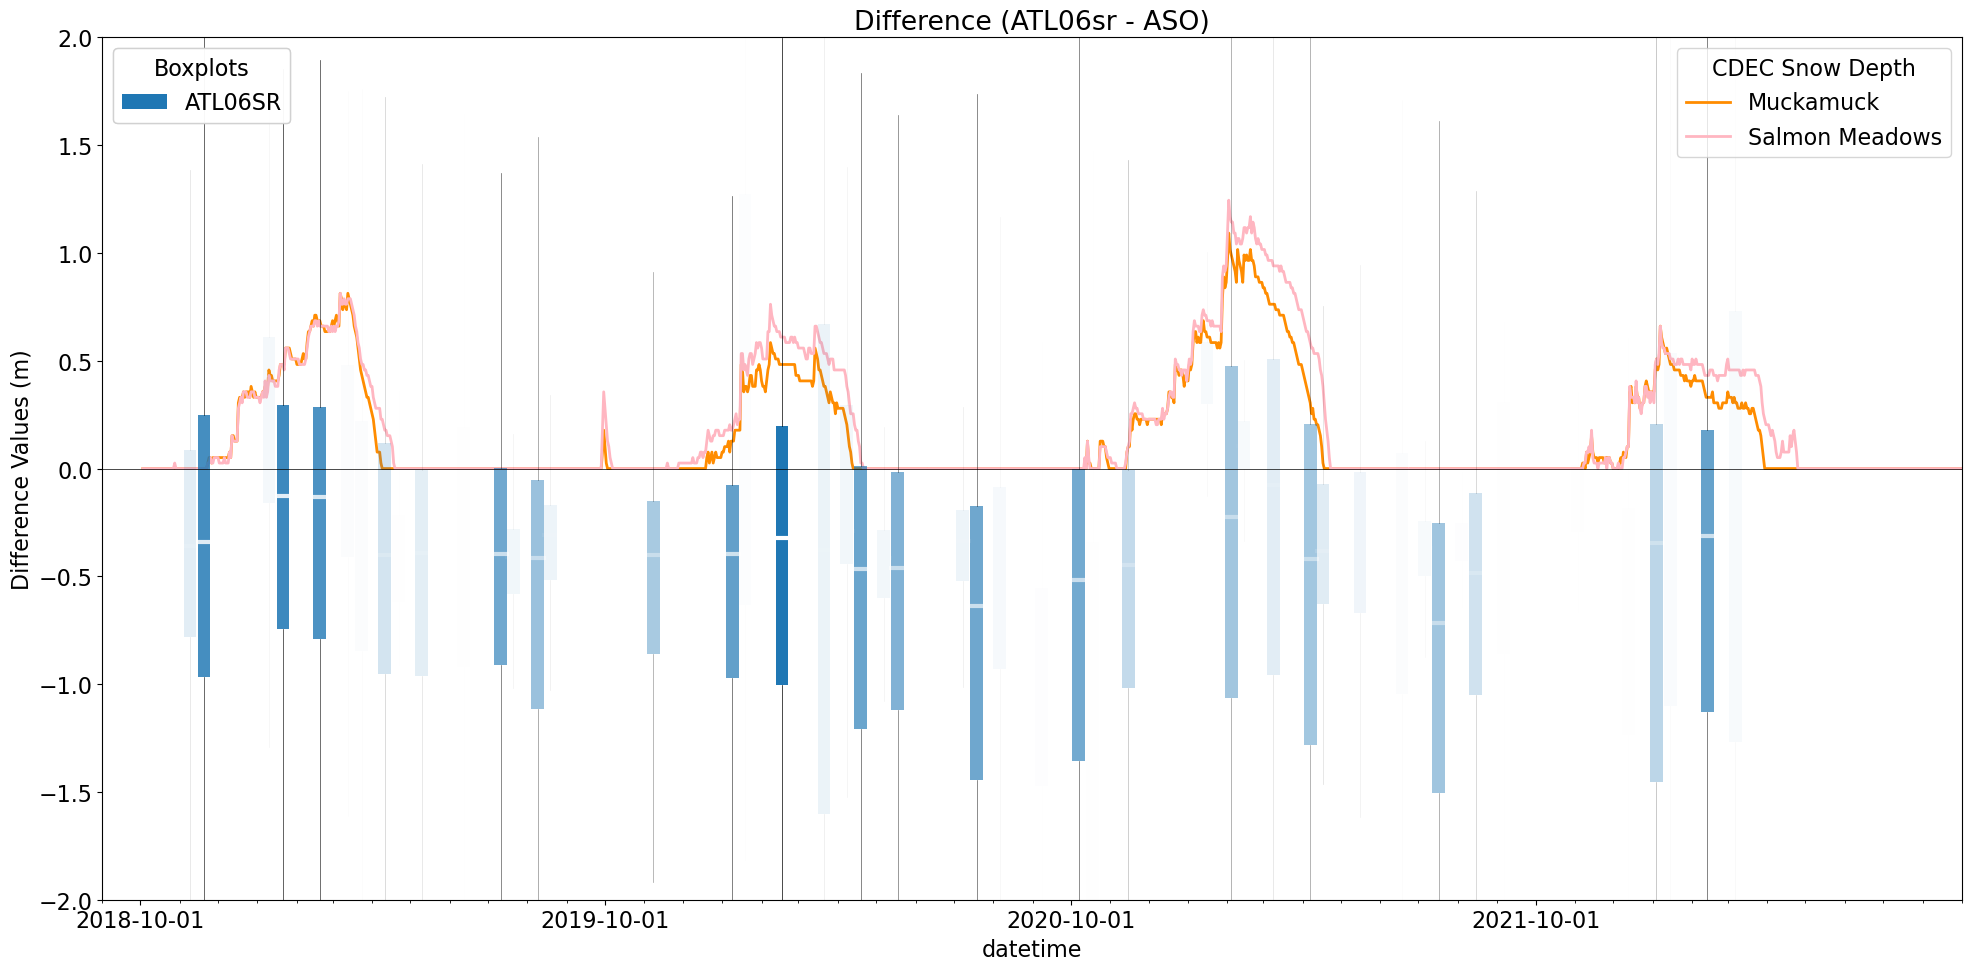

In [29]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'difference', clim=(-2,2), title='Difference (ATL06sr - ASO)', name ='boxplots_difference.jpeg')

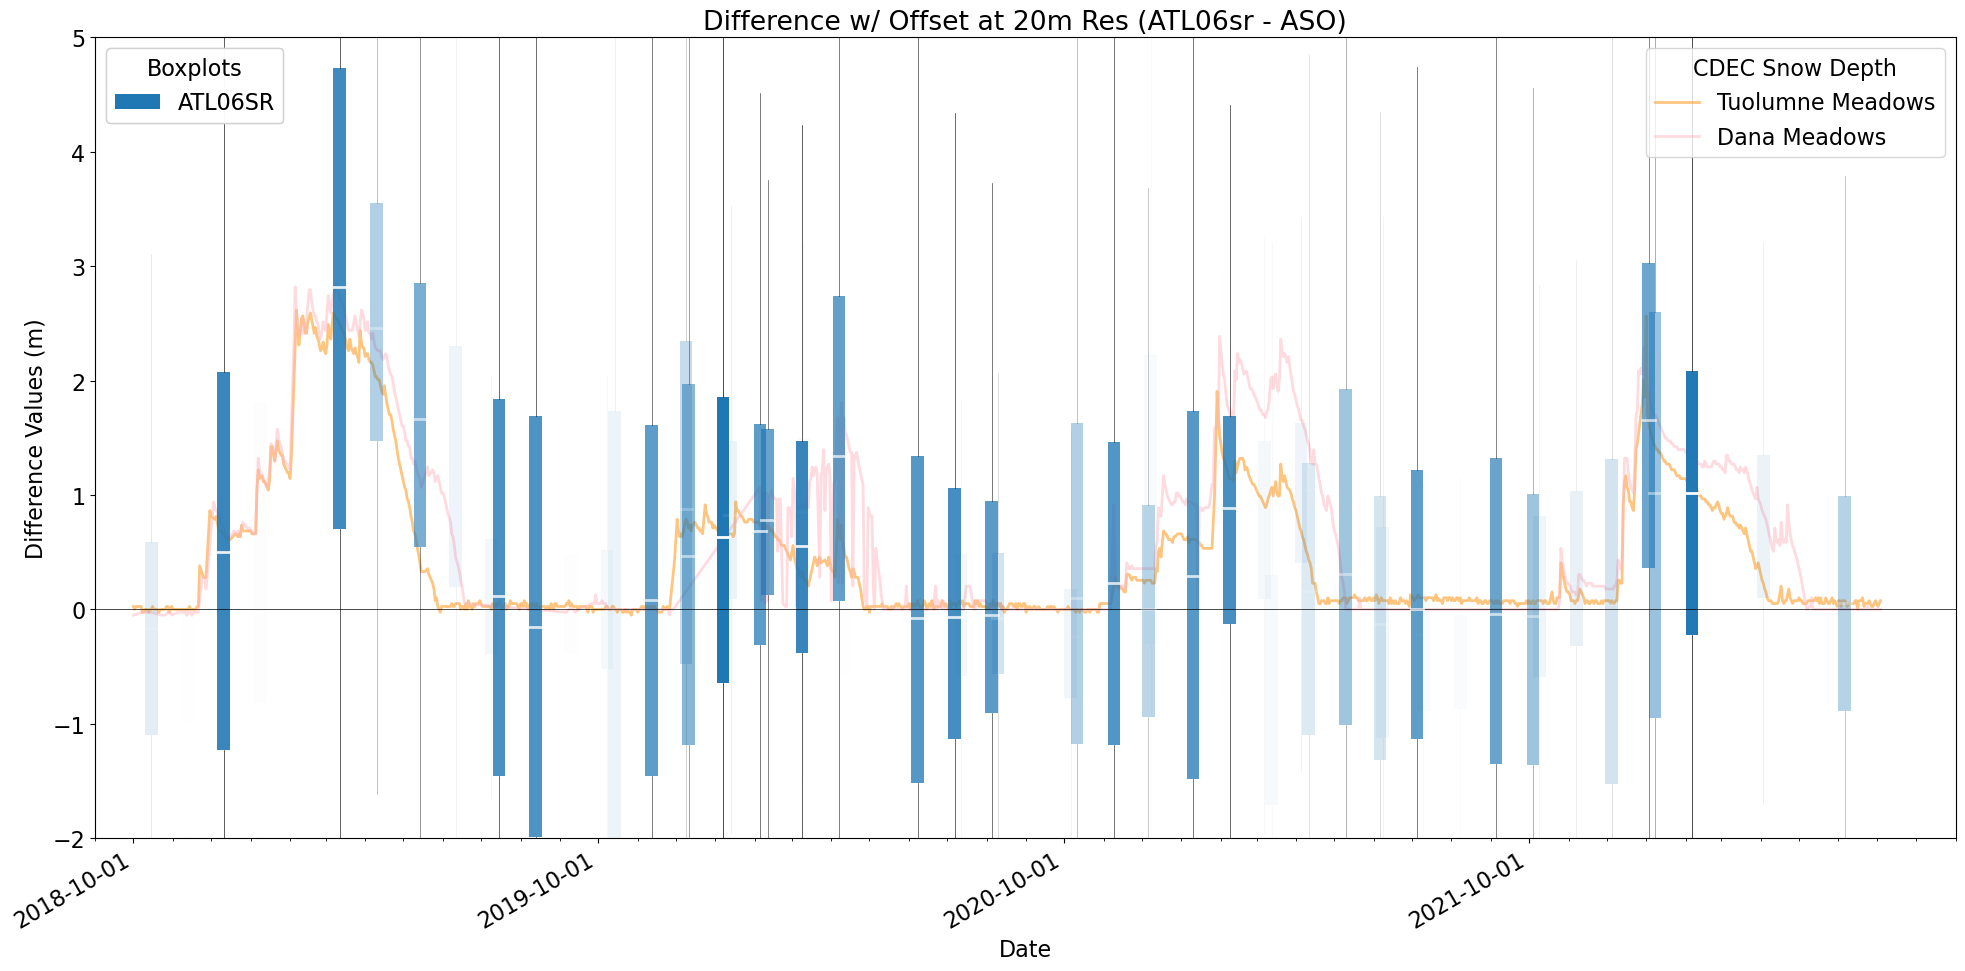

In [169]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus_20m', clim=(-2,5), title = 'Difference w/ Offset at 20m Res (ATL06sr - ASO)', name = 'boxplots_diffplus_20m.jpeg')

### Transparent boxplots with ASO Snow-On Data

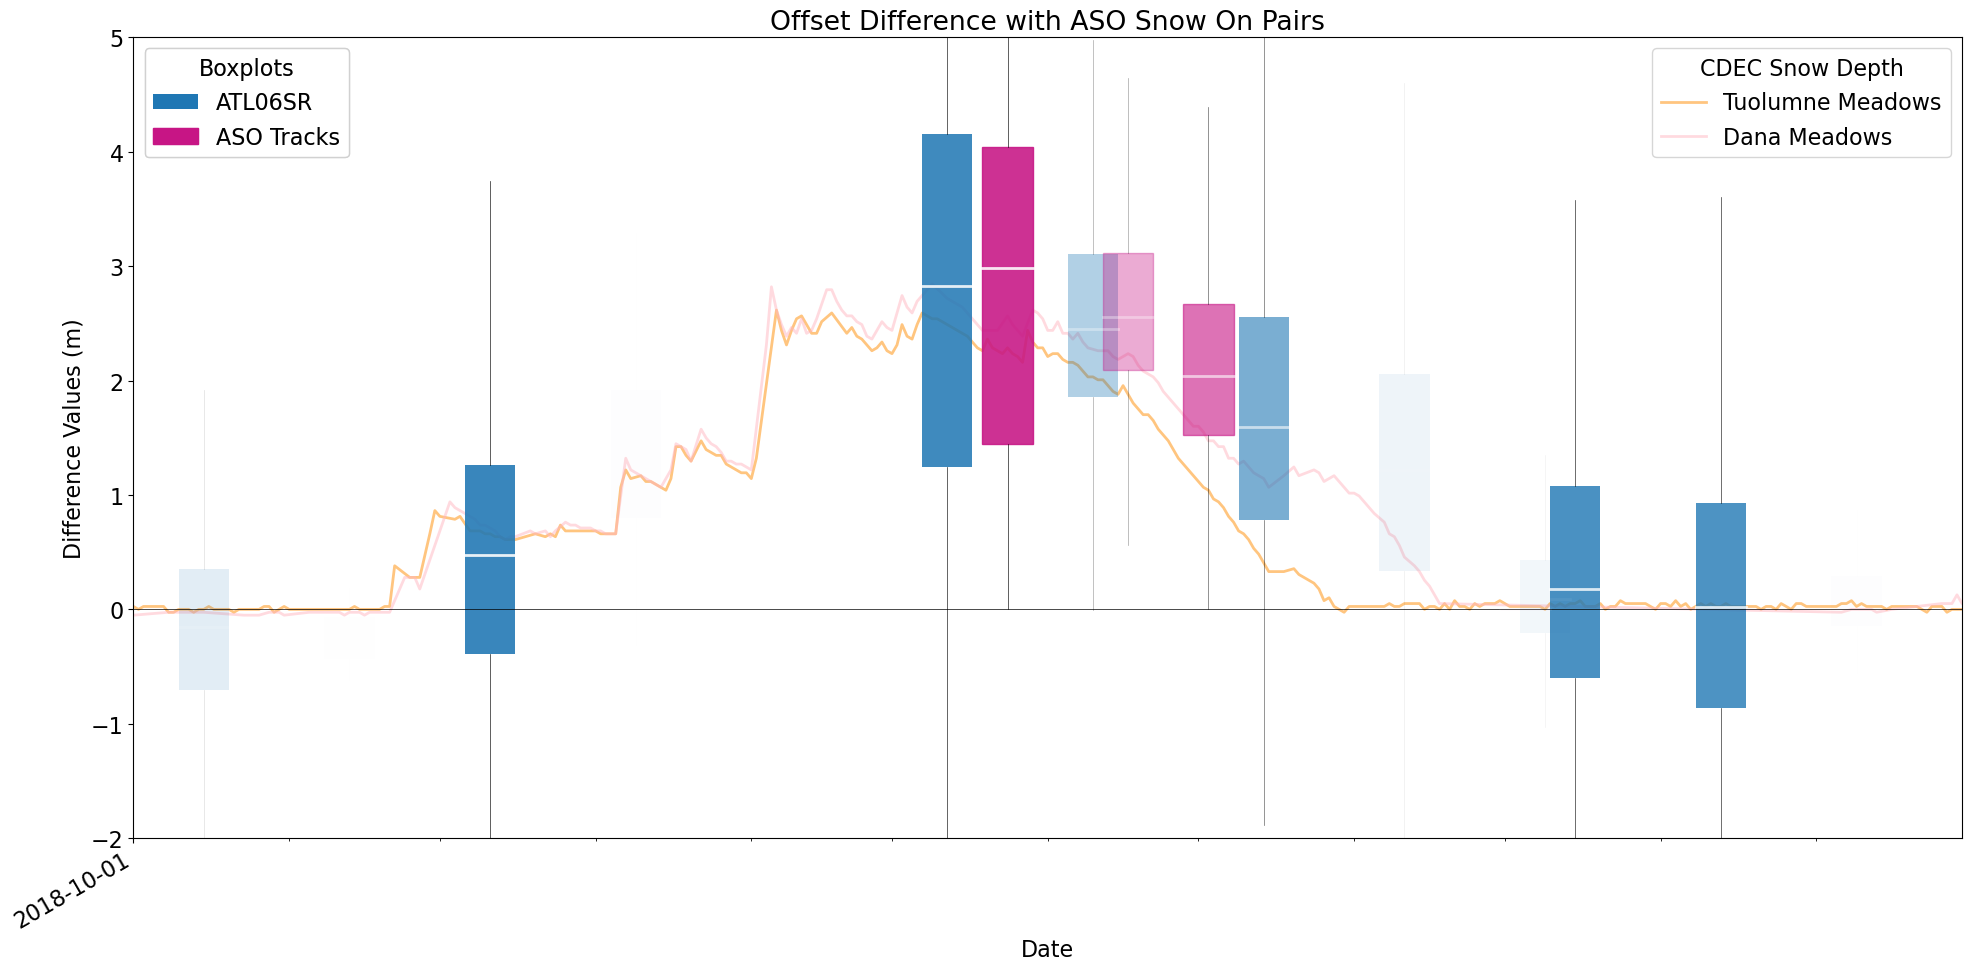

In [170]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf, 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Offset Difference with ASO Snow On Pairs', name = 'boxplots_asotracks_2019.jpeg')

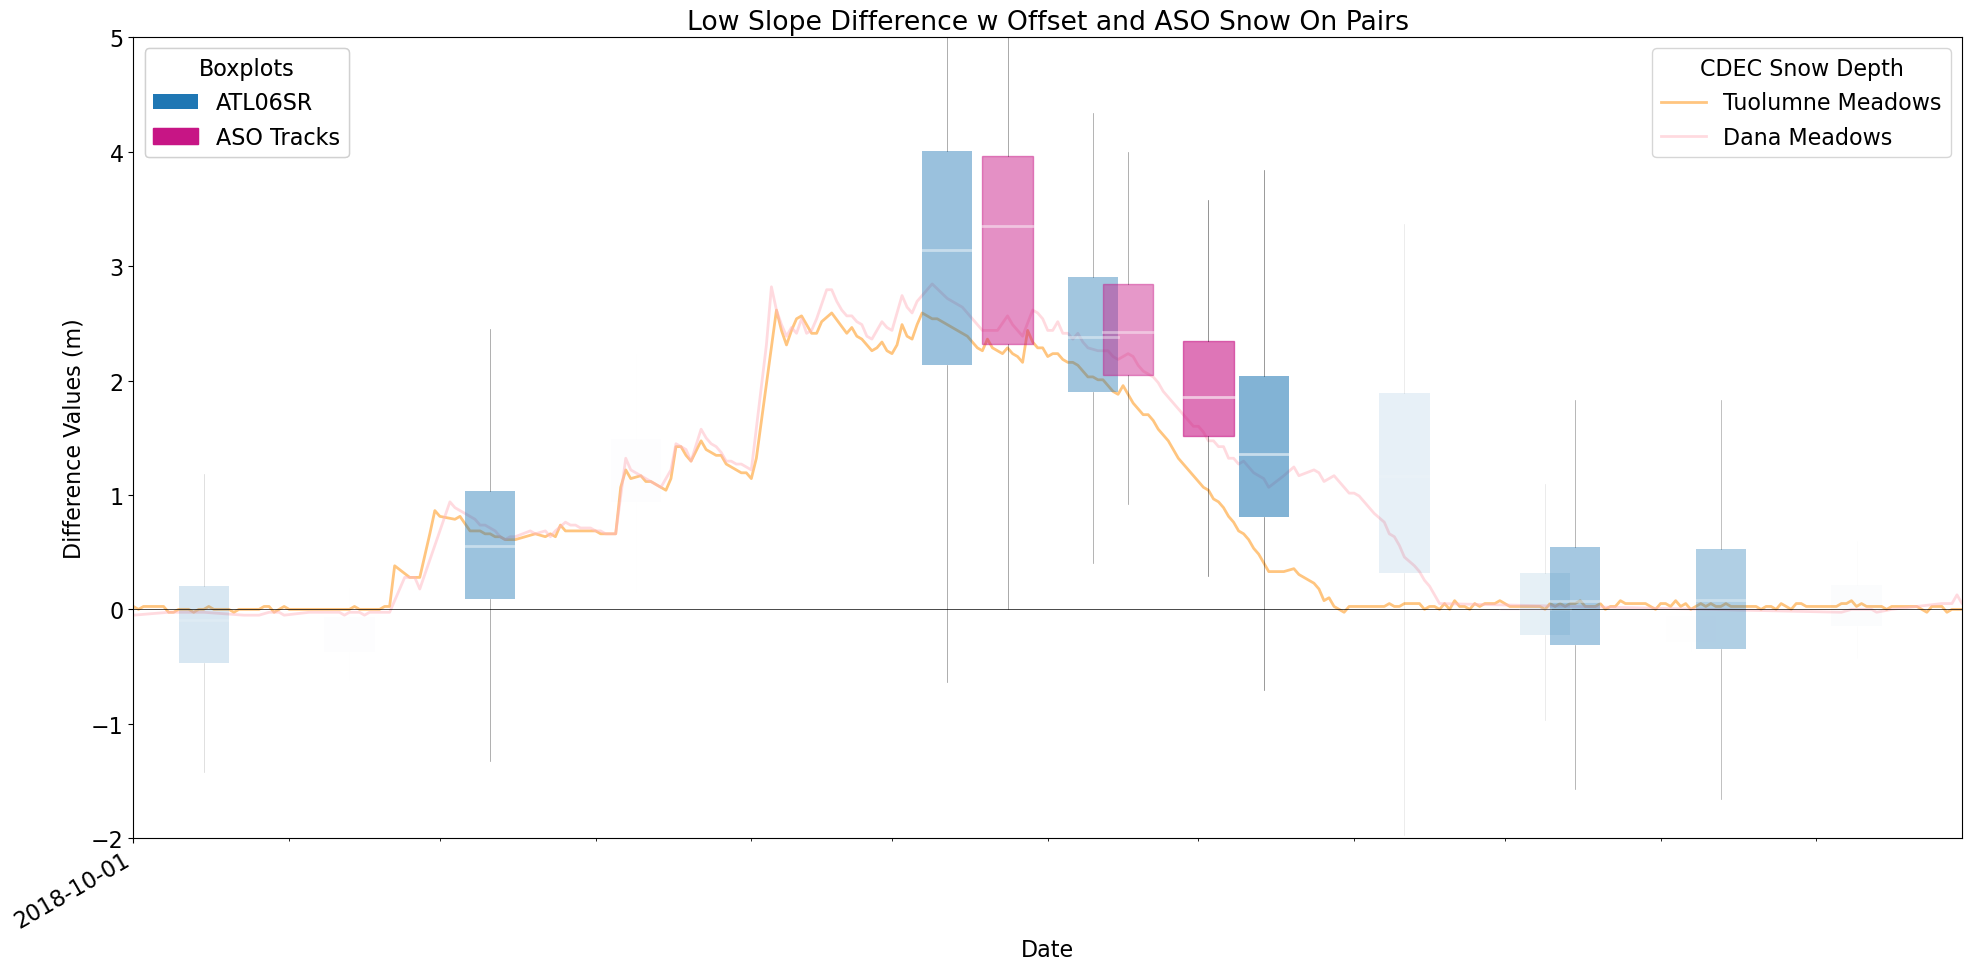

In [171]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_2019_lowslope.jpeg')

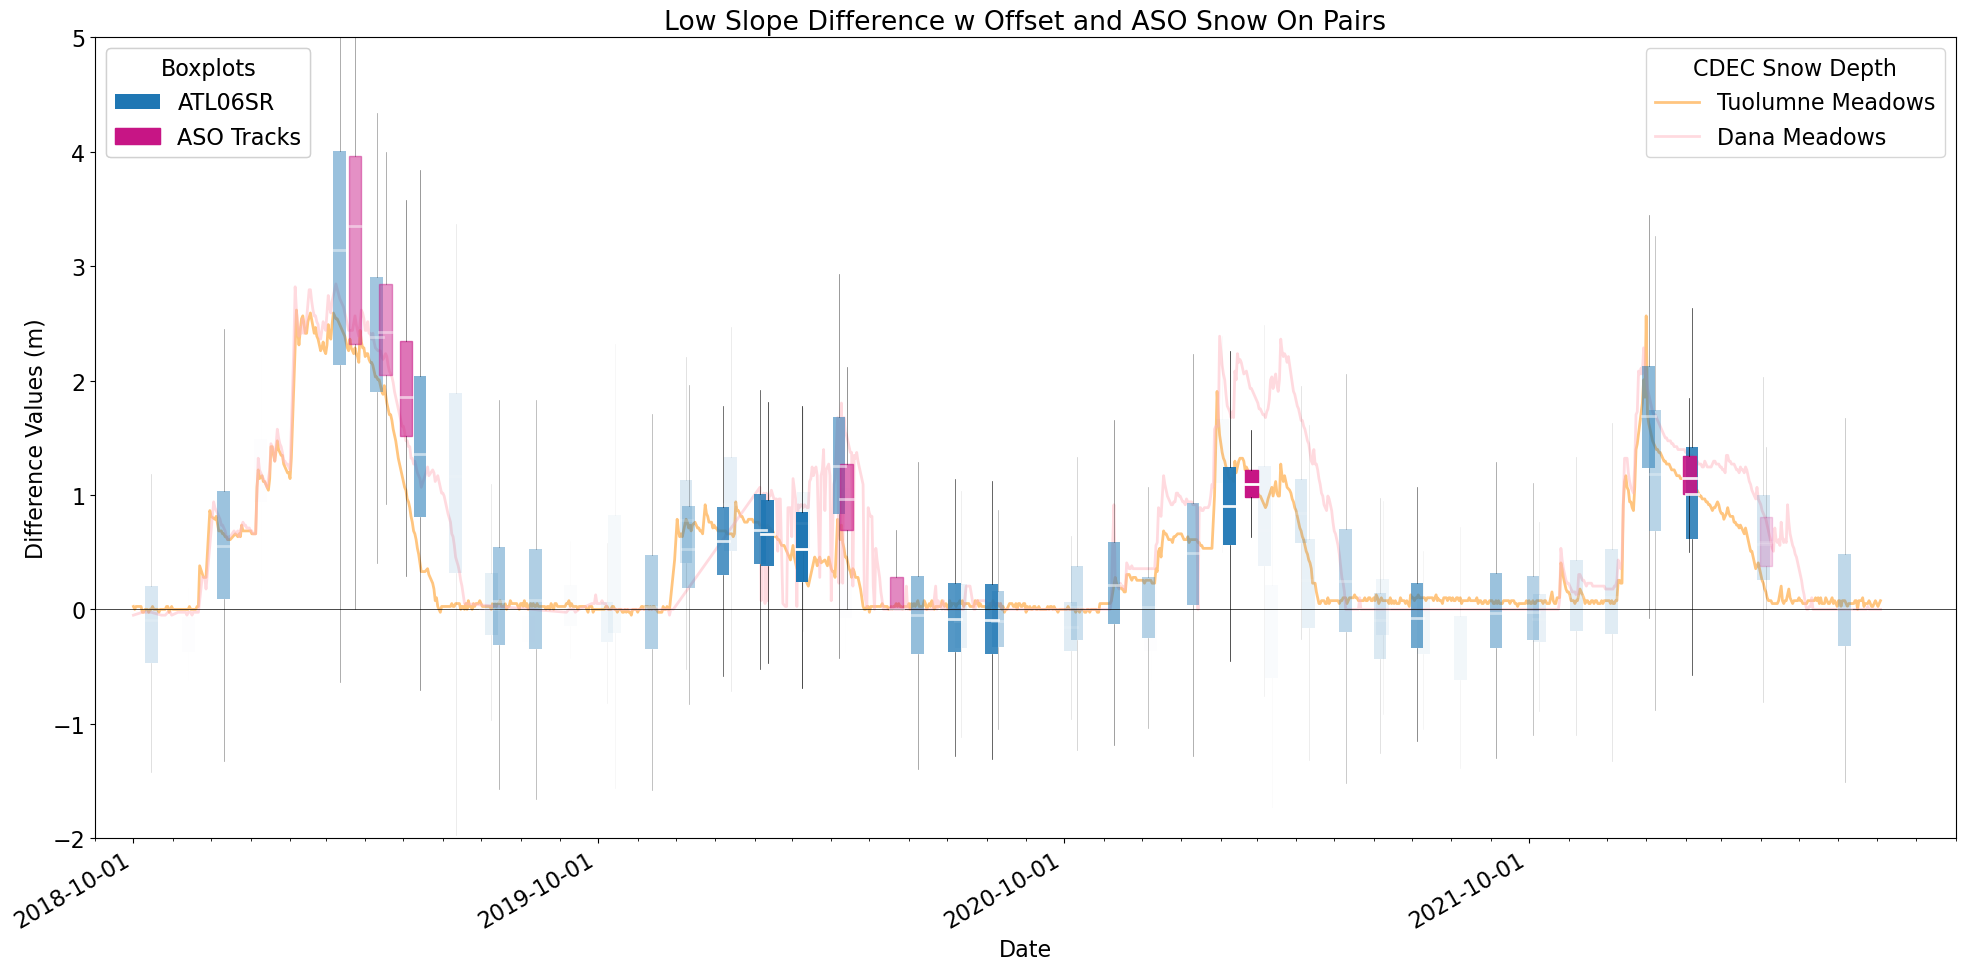

In [172]:
dt_min_plot = '2018-09-01'
dt_max_plot = '2022-09-01'
boxplot_date_aso_all(atl06sr_gdf[atl06sr_gdf['slope_20m'] < 10], 'diff_plus', 'ASO_snowon', clim=(-2,5), title='Low Slope Difference w Offset and ASO Snow On Pairs', name = 'boxplots_asotracks_lowslope.jpeg')

## Transparent Boxplots with ASO Snow-On at ATL06SR and Entire Basin

#### Use rasterstats to make boxplots of ASO data for the Study area

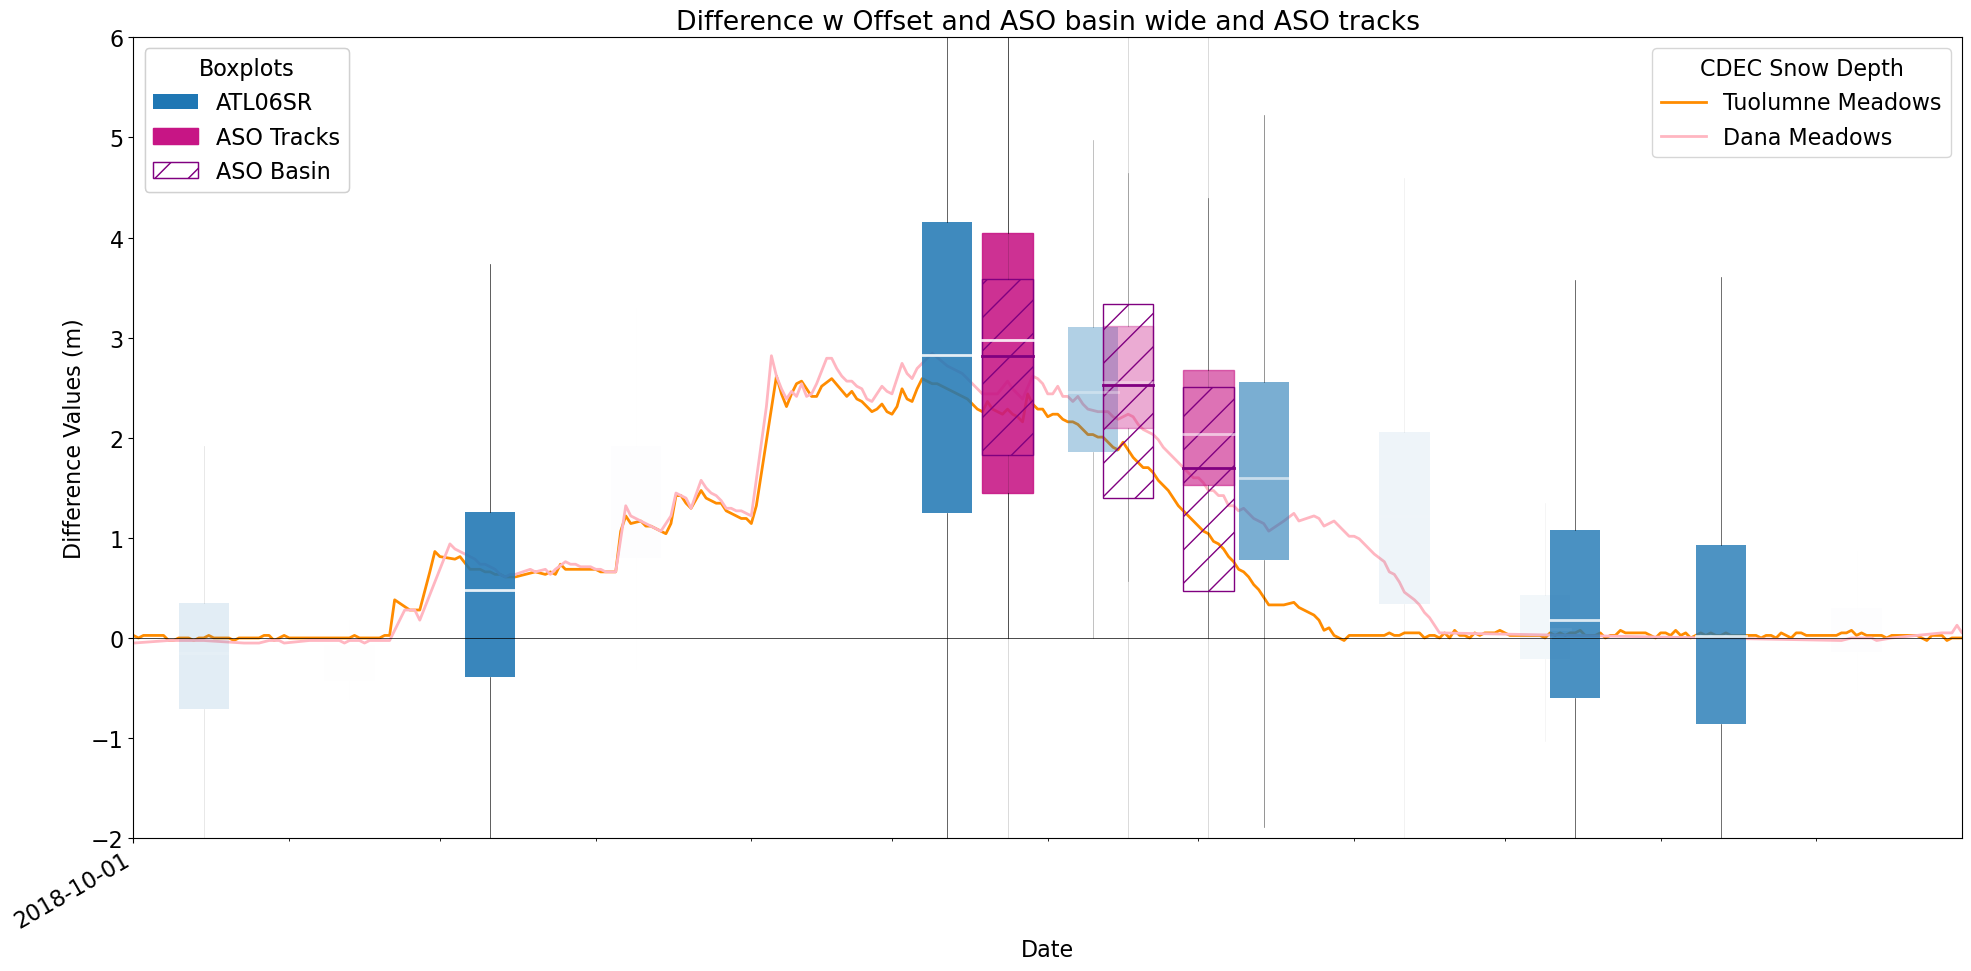

In [217]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2019-09-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-2,6), name = 'boxplots_asotracks_basin_2019.jpeg')

### Look at all years of data:

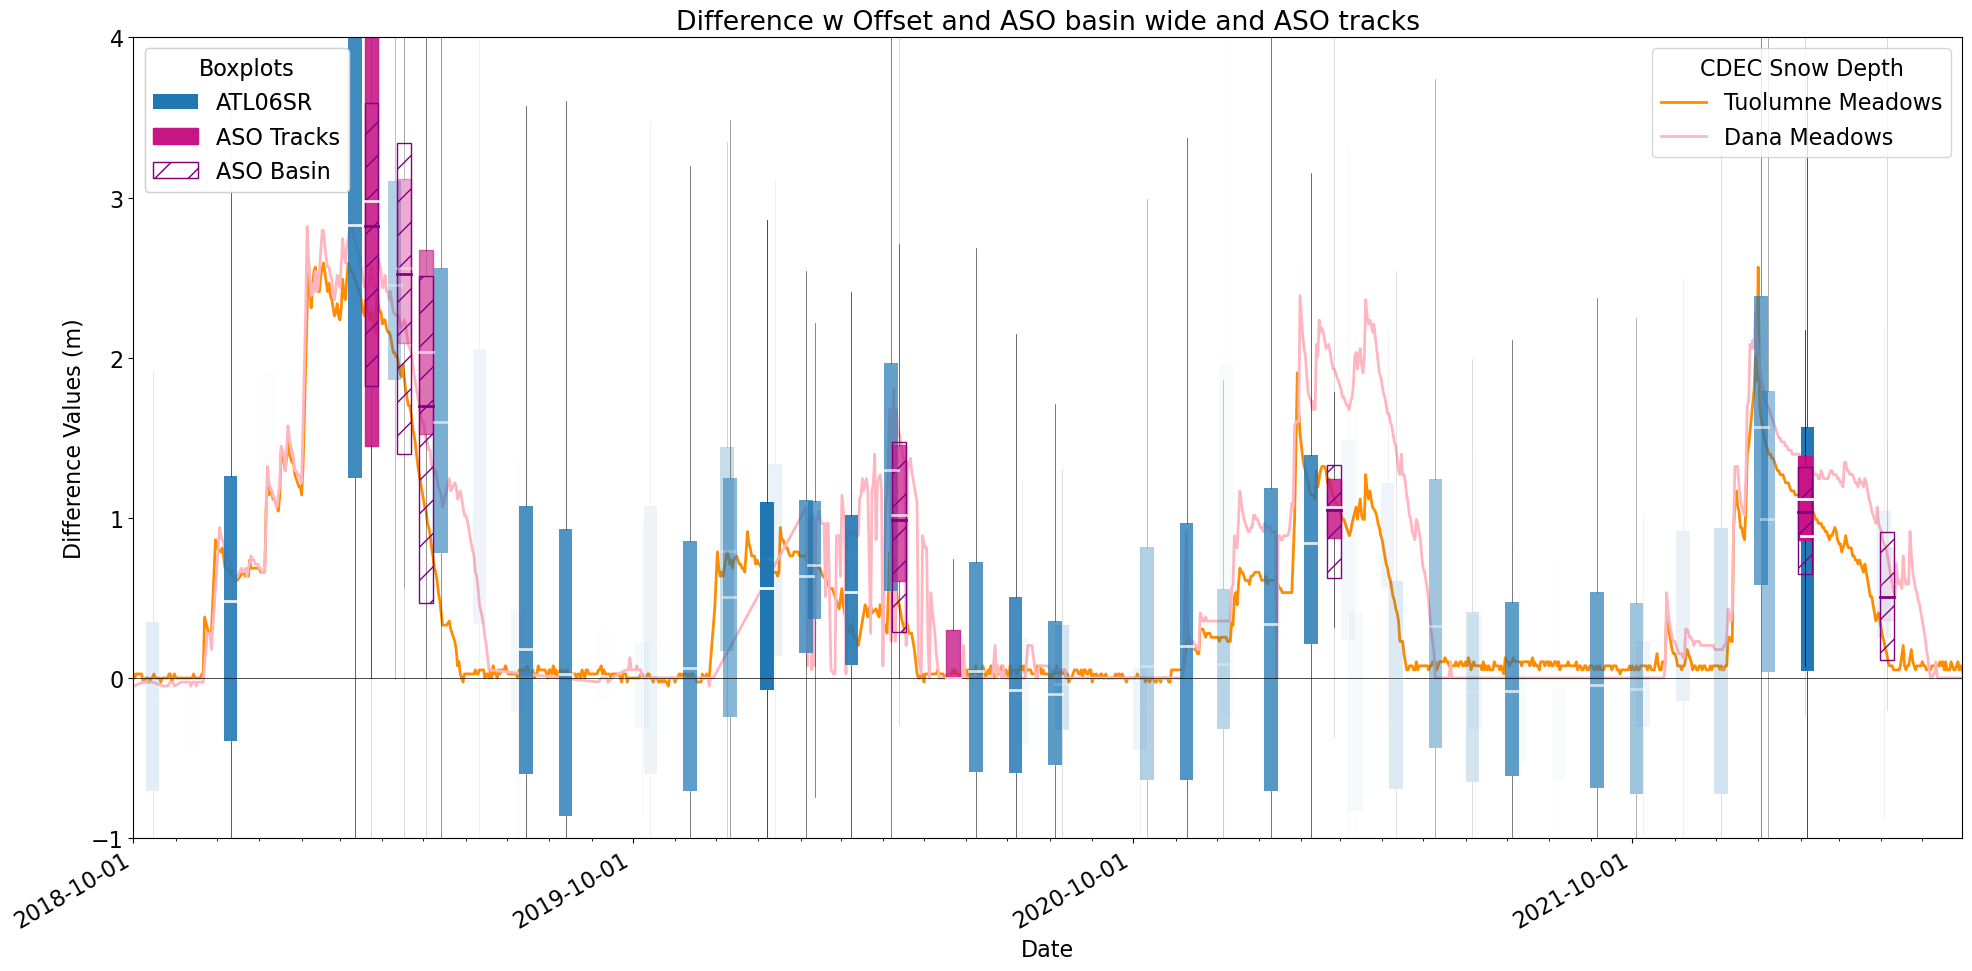

In [219]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf, col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, clim=(-1,4), name = 'boxplots_cdec_aso_allyears.jpeg')

## Look at only ATL06SR and ASO Temporal Pairs

In [153]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2019, 7, 9),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

In [ ]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf[atl06sr_gdf['acqdate'].isin(atl06_dates)], col='diff_plus', col_aso='ASO_snowon', rasterstats=stats_dict, name = 'boxplots_asotracks_basin.jpeg')

# Plot ATL06SR Data Within 5km Radius of CDEC Sites

In [ ]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[2, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of TUM', name = 'boxplots_asotracks_basin_tum5.jpeg')

In [ ]:
dt_min_plot = '2018-10-01'
dt_max_plot = '2022-05-30'
boxplot_date_aso_all(df=atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])], col='diff_plus', col_aso='ASO_snowon', region_aso=cdec_geom.loc[3, 'geometry'], rasterstats=stats_dict, clim=(-1,5), title = 'Difference w Offset and ASO basin wide and ASO tracks within 5km Radius of DAN', name = 'boxplots_asotracks_basin_dan5.jpeg')

# Calculate Differences Between ATL06SR and ASO Pairs

## List of alignable dates:
**ASO**      |         **IS2**  
2019-03-24   |  datetime.date(2019, 3, 12)  (12)  
2019-04-17   |  datetime.date(2019, 4, 10)  (7)  
2019-05-03   |  datetime.date(2019, 5, 14)  (11)  
-> snowoff? 2019-07-05   |  datetime.date(2019, 7, 9)   (4)  
2020-04-13   |   datetime.date(2020, 4, 7)  (5)  
? 2020-05-22 |    datetime.date(2020, 6, 8)  (16?)  
? 2021-02-25 |    datetime.date(2021, 2, 8)  (17)  
2022-02-04   |  datetime.date(2022, 2, 6)    (2)  
2022-04-05   |  datetime.date(2022, 4, 3)?   (2)  

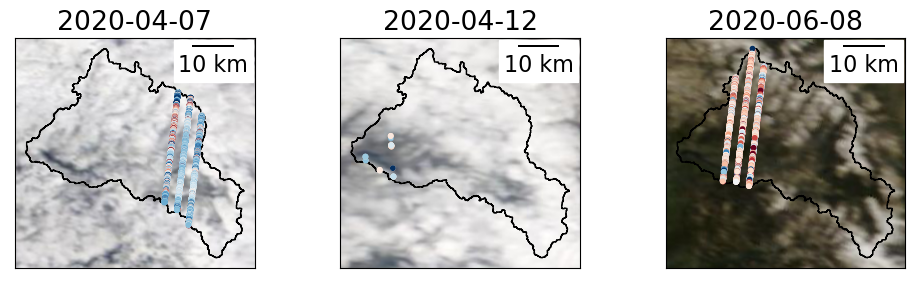

In [203]:
dates_2020 = [datetime.date(2020,4,7), datetime.date(2020,4,12), datetime.date(2020,6,8)]
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, dates_2020):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf[atl06sr_gdf['acqdate'] == date].plot(ax=ax, column='diff_plus', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

In [248]:
aso_date_list = []
for fn in aso_fn_winters:
    date_string = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-2]
    date = datetime.datetime.strptime(date_string, "%Y%m%d").date()
    aso_date_list.append(date)

In [249]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [250]:
print('aso length:', len(aso_date_list))
print('atl06sr length:', len(atl06_dates))

aso length: 8
atl06sr length: 8


In [251]:
comp_table = pd.DataFrame()
comp_table.index = pd.DatetimeIndex(data=sorted(atl06_dates + aso_date_list))
comp_table['acqdate'] = comp_table.index.date

In [252]:
#atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus']
comp_table['ATL06SR'] = ''
comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ATL06SR'] = True
comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ATL06SR'] = False

In [253]:
comp_table['ASO'] = ''
comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ASO'] = False
comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ASO'] = True

In [254]:
comp_table['pair'] = ''
for i in range(len(comp_table)):
    comp_table['pair'][i:i+1] = int(i/2)

In [255]:
comp_table['median'] = ''
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['ASO_snowon_date']==date,'ASO_snowon'])

In [256]:
comp_table['pair'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object)

In [257]:
comp_table['median_diff'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'median_diff'] = np.diff(comp_table[comp_table['pair']==i]['median'])

In [556]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,iqr,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_dif_percent,basin_iqr,iqr_dif_percent,median_track_percent,iqr_track_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,2.909036,-0.312845,12,2.4892,2.603043,-0.2032,-0.046256,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,2.596191,-0.312845,12,2.286,2.556787,-0.2032,-0.046256,2.820521,5.518711,1.763427,-17.740722,5.221507,-12.05014
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,1.248204,-0.2244,7,2.032,2.295215,-0.1524,-0.151303,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,1.023804,-0.2244,7,1.8796,2.143911,-0.1524,-0.151303,2.524292,4.218105,1.942124,-11.554357,4.161163,-21.918265
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,1.147949,0.630284,11,1.0414,1.517066,-0.635,-0.280534,1.698732,-26.005614,2.043902,30.837289,-21.677132,54.905226
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,1.778233,0.630284,11,0.4064,1.236532,-0.635,-0.280534,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,1.422136,-0.578227,6,0.7112,1.196654,-0.254,-0.045494,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,0.843909,-0.578227,6,0.4572,1.15116,-0.254,-0.045494,0.983526,-28.133181,1.181436,-48.942736,-27.140498,-68.517762
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,0.298129,1.01513,17,0.0508,0.009852,0.0254,-0.006384,0.010931,381.066764,0.337922,300.403707,inf,340.499902
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,1.313259,1.01513,17,0.0762,0.003468,0.0254,-0.006384,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
comp_table['iqr'] = ''
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['ASO_snowon_date']==date,'ASO_snowon'])

In [259]:
comp_table['iqr_diff'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'iqr_diff'] = np.diff(comp_table[comp_table['pair']==i]['iqr'])

In [263]:
comp_table['date_offset'] = ''
for i in range(len(comp_table)):
    if i%2 != 0:
        comp_table.loc[comp_table['pair']==int(i/2), 'date_offset'] = np.subtract(comp_table.index[i],comp_table.index[i-1]).days

In [308]:
comp_table['tum_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table.index:
    comp_table.loc[comp_table.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_interp']

In [309]:
comp_table['dan_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table.index:
    comp_table.loc[comp_table.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_interp']

In [310]:
comp_table['delta_tum'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'delta_tum'] = np.diff(comp_table[comp_table['pair']==i]['tum_depth'])

In [311]:
comp_table['delta_dan'] = ''
for i in comp_table['pair'].unique():
    comp_table.loc[comp_table['pair']==i, 'delta_dan'] = np.diff(comp_table[comp_table['pair']==i]['dan_depth'])

Text(0, 0.5, 'difference in the ASO \nand ATL06SR medians')

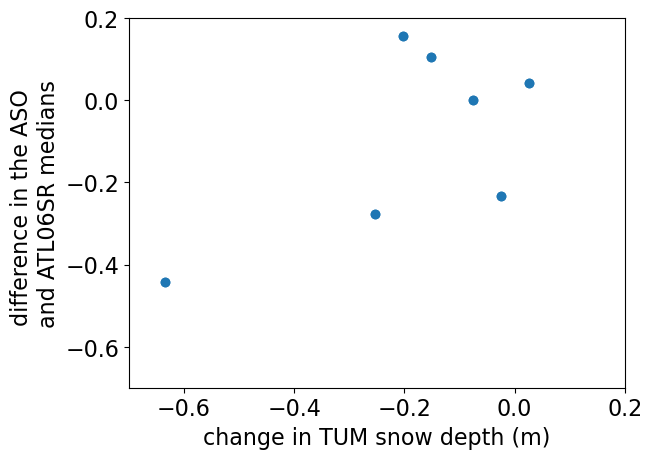

In [312]:
fig, ax = plt.subplots()
plt.scatter(comp_table['delta_tum'], comp_table['median_diff'])
plt.xlabel('change in TUM snow depth (m)')
#plt.axis('square')
plt.ylim(-0.7, 0.2)
plt.xlim(-0.7, 0.2)
plt.ylabel('difference in the ASO \nand ATL06SR medians')
#plt.axis('square')

(-0.5, 0.3)

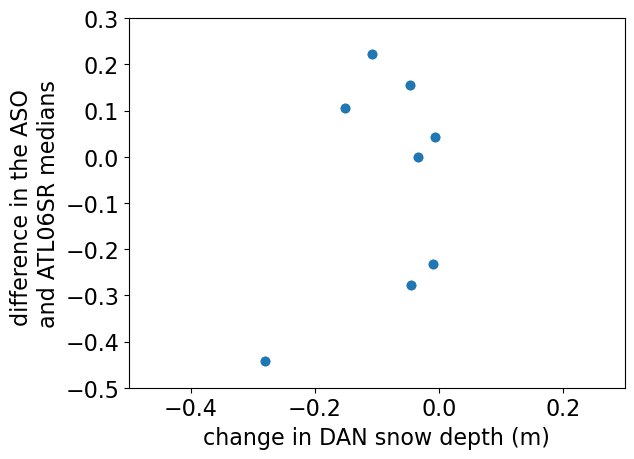

In [313]:
fig, ax = plt.subplots()
plt.scatter(comp_table['delta_dan'], comp_table['median_diff'])
plt.xlabel('change in DAN snow depth (m)')
plt.ylabel('difference in the ASO \nand ATL06SR medians')
plt.ylim(-0.5, 0.3)
plt.xlim(-0.5, 0.3)

In [508]:
comp_table.head()

,acqdate,ATL06SR,ASO,pair,median,median_diff,iqr,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_dif_percent,basin_iqr,iqr_dif_percent,median_track_percent,iqr_track_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,2.909036,-0.312845,12,2.4892,2.603043,-0.2032,-0.046256,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,2.596191,-0.312845,12,2.286,2.556787,-0.2032,-0.046256,2.820521,5.518711,1.763427,-17.740722,5.221507,-12.05014
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,1.248204,-0.2244,7,2.032,2.295215,-0.1524,-0.151303,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,1.023804,-0.2244,7,1.8796,2.143911,-0.1524,-0.151303,2.524292,4.218105,1.942124,-11.554357,4.161163,-21.918265
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,1.147949,0.630284,11,1.0414,1.517066,-0.635,-0.280534,1.698732,-26.005614,2.043902,30.837289,-21.677132,54.905226


Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

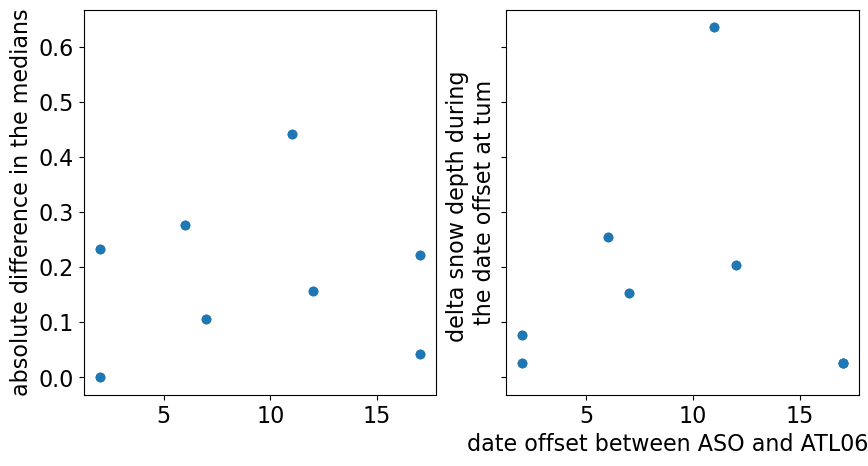

In [510]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table['date_offset'], comp_table['median_diff'].abs())
#ax[0].set_xlabel('date offset between ASO and ATL06SR')
ax[0].set_ylabel('absolute difference in the medians')

ax[1].scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
ax[1].set_xlabel('date offset between ASO and ATL06SR')
ax[1].set_ylabel('delta snow depth during \nthe date offset at tum')

Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

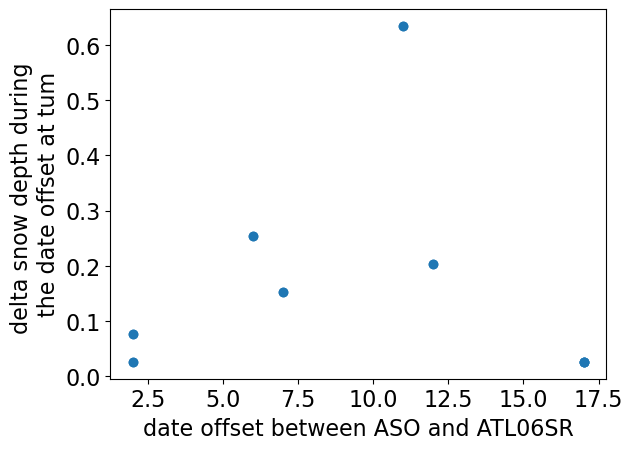

In [365]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('delta snow depth during \nthe date offset at tum')

In [415]:
comp_table['median_dif_percent'][1]

5.518710759098733

Text(0, 0.5, 'percent difference in the medians \nthe compared to median depth in the basin')

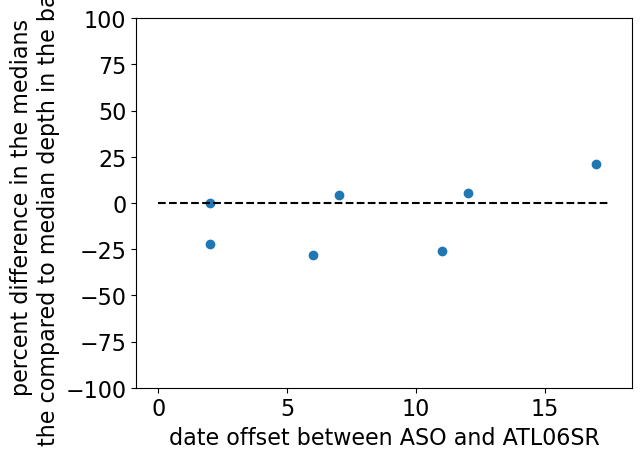

In [431]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['median_dif_percent'])
plt.ylim(-100, 100)
plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('percent difference in the medians \nthe compared to median depth in the basin')

Text(0, 0.5, 'percent difference in the iqrs \ncompared to the iqr in the basin')

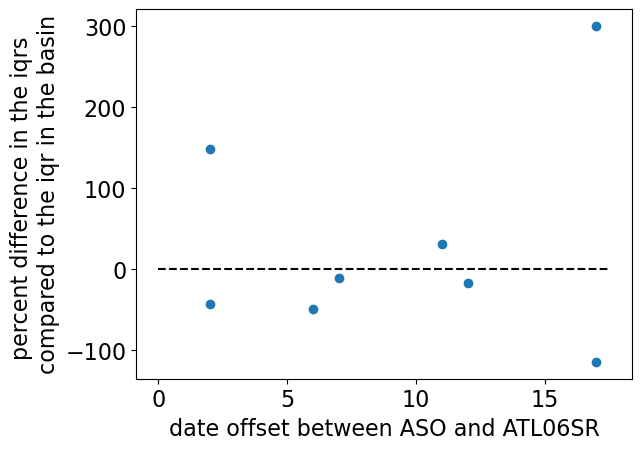

In [436]:
fig, ax = plt.subplots()
plt.scatter(comp_table['date_offset'], comp_table['iqr_dif_percent'])
#plt.ylim(-100, 100)
plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.xlabel('date offset between ASO and ATL06SR')
plt.ylabel('percent difference in the iqrs \ncompared to the iqr in the basin')

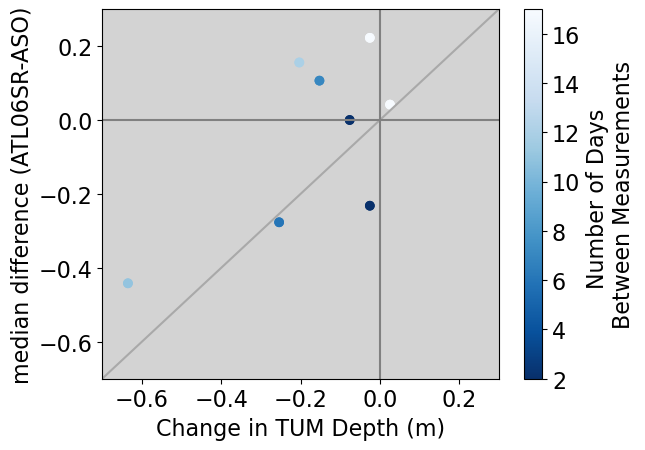

In [575]:
x = np.linspace(-7,0.3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_table['delta_tum'], comp_table['median_diff'], c=comp_table['date_offset'], cmap='Blues_r')
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
plt.colorbar(c, label='Number of Days \nBetween Measurements')
#plt.ylim(-100, 100)
#plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.ylim(-0.7, 0.3)
plt.xlim(-0.7, 0.3)
plt.xlabel('Change in TUM Depth (m)')
plt.ylabel('median difference (ATL06SR-ASO)')
ax.set_facecolor('lightgrey')

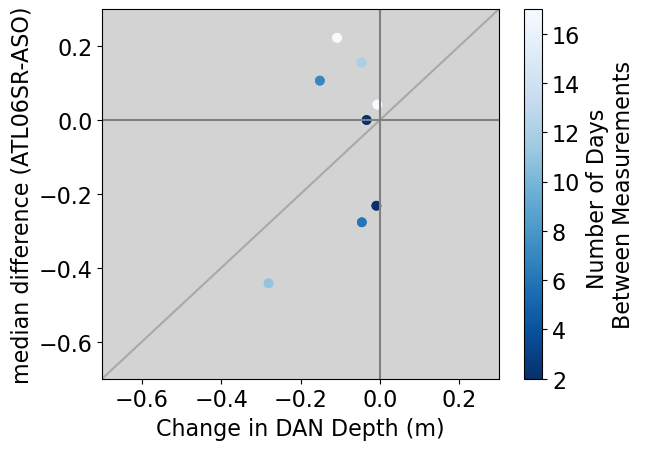

In [565]:
x = np.linspace(-0.7,0.3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_table['delta_dan'], comp_table['median_diff'], c=comp_table['date_offset'], cmap='Blues_r')
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
plt.colorbar(c, label='Number of Days \nBetween Measurements')
#plt.ylim(-100, 100)
#plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
plt.ylim(-0.7, 0.3)
plt.xlim(-0.7, 0.3)
plt.xlabel('Change in DAN Depth (m)')
plt.ylabel('median difference (ATL06SR-ASO)')
ax.set_facecolor('lightgrey')

In [405]:
# written by Hannah Besso, Oct 14, 2022

def build_basin_df(raster_list = None, region = None):
    #dict_list = []
    #date_list = []
    #count = []
    stats_df = pd.DataFrame()
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
        rasterstats[0]['iqr'] = rasterstats[0]['percentile_75'] - rasterstats[0]['percentile_25']
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        date2 = pd.to_datetime(date)
        stats_df = pd.concat([stats_df, pd.DataFrame(rasterstats[0], index=[date2])])
    stats_df['acqdate'] = stats_df.index.date
    return stats_df

In [406]:
basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)

In [407]:
basin_df

,min,max,mean,count,median,percentile_25,percentile_75,iqr,acqdate
2019-03-24,-9999.000000,22.367649,-124.838010,2953037,2.820521,1.825860,3.589287,1.763427,2019-03-24
2019-04-17,-9999.000000,22.962400,-123.848006,2953037,2.524292,1.395474,3.337599,1.942124,2019-04-17
2019-05-03,-9999.000000,42.400269,-125.809994,2953037,1.698732,0.466960,2.510863,2.043902,2019-05-03
2020-04-13,-0.292035,21.189863,0.983854,2646253,0.983526,0.289719,1.471155,1.181436,2020-04-13
2020-05-22,-0.218361,20.824833,0.265674,2792407,0.010931,0.000000,0.337922,0.337922,2020-05-22
2021-02-25,-0.366888,7.820531,0.966758,2906850,1.049031,0.621652,1.327524,0.705872,2021-02-25
2022-02-04,-0.232013,11.518790,1.000802,1235354,1.036890,0.647384,1.318633,0.671249,2022-02-04
2022-04-05,-0.200172,11.080725,0.609790,1157340,0.508277,0.115128,0.909294,0.794165,2022-04-05


In [416]:
comp_table['basin_median'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'basin_median'] = basin_df.loc[basin_df['acqdate']==date,'median']

In [475]:
comp_table['median_dif_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_dif_percent'] = comp_table.loc[comp_table['acqdate']==date, 'median_diff'] / comp_table.loc[comp_table['acqdate']==date, 'basin_median'] * 100

In [476]:
comp_table['median_track_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'median_diff'] / comp_table.loc[comp_table['acqdate']==date, 'median'] * 100

In [480]:
comp_table['iqr_track_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'iqr_diff'] / comp_table.loc[comp_table['acqdate']==date, 'iqr'] * 100

In [432]:
comp_table['basin_iqr'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] = basin_df.loc[basin_df['acqdate']==date,'iqr']

In [433]:
comp_table['iqr_dif_percent'] = np.nan
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'iqr_dif_percent'] = comp_table.loc[comp_table['acqdate']==date, 'iqr_diff'] / comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] * 100

In [481]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,iqr,iqr_diff,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_dif_percent,basin_iqr,iqr_dif_percent,median_track_percent,iqr_track_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,2.909036,-0.312845,12,2.4892,2.603043,-0.2032,-0.046256,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,2.596191,-0.312845,12,2.286,2.556787,-0.2032,-0.046256,2.820521,5.518711,1.763427,-17.740722,5.221507,-12.05014
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,1.248204,-0.2244,7,2.032,2.295215,-0.1524,-0.151303,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,1.023804,-0.2244,7,1.8796,2.143911,-0.1524,-0.151303,2.524292,4.218105,1.942124,-11.554357,4.161163,-21.918265
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,1.147949,0.630284,11,1.0414,1.517066,-0.635,-0.280534,1.698732,-26.005614,2.043902,30.837289,-21.677132,54.905226
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,1.778233,0.630284,11,0.4064,1.236532,-0.635,-0.280534,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,1.422136,-0.578227,6,0.7112,1.196654,-0.254,-0.045494,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,0.843909,-0.578227,6,0.4572,1.15116,-0.254,-0.045494,0.983526,-28.133181,1.181436,-48.942736,-27.140498,-68.517762
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,0.298129,1.01513,17,0.0508,0.009852,0.0254,-0.006384,0.010931,381.066764,0.337922,300.403707,inf,340.499902
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,1.313259,1.01513,17,0.0762,0.003468,0.0254,-0.006384,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
comp_table.to_csv('../../figures/comp_table.csv')

In [486]:
np.nanmedian(comp_table['median_diff'])

0.020830463217976103

In [490]:
np.nanmin(comp_table['median_diff'].abs())

4.899748319076025e-06

In [491]:
np.nanmax(comp_table['median_diff'].abs())

0.44176575335950474

In [494]:
comp_table['median_track_percent'].describe()

count     8.000000
unique    8.000000
top       5.221507
freq      1.000000
Name: median_track_percent, dtype: float64

In [496]:
np.nanmin(comp_table['median_track_percent'].abs())

0.0008307312229049511

In [497]:
np.nanmax(comp_table['median_track_percent'].abs())

inf

In [498]:
np.nanmedian(comp_table['median_track_percent'].abs())

20.79296636968199

In [505]:
np.nanmin(comp_table['iqr_diff'].abs())

0.22440000580900232

In [506]:
np.nanmax(comp_table['iqr_diff'].abs())

1.0151301455530302

In [507]:
np.nanmedian(comp_table['iqr_diff'].abs())

0.6042556821217886

In [539]:
np.nanmin(comp_table['iqr_track_percent'].abs())

12.050140086831174

In [540]:
np.nanmax(comp_table['iqr_track_percent'].abs())

340.4999023858529

In [542]:
np.nanmedian(comp_table['iqr_track_percent'].abs())

71.7444662298708

In [ ]:
# Write to file
    with open(
        os.path.splitext(
            os.path.basename(__file__))[0] + ".tbl", "w") as f:

        format = "l" + \
            "@{\hskip 12pt}" +\
            4*"S[table-format = 2.2]"

        f.write(df.head()
                .to_latex(index=False,
                          escape=False,
                          column_format=format)
                )



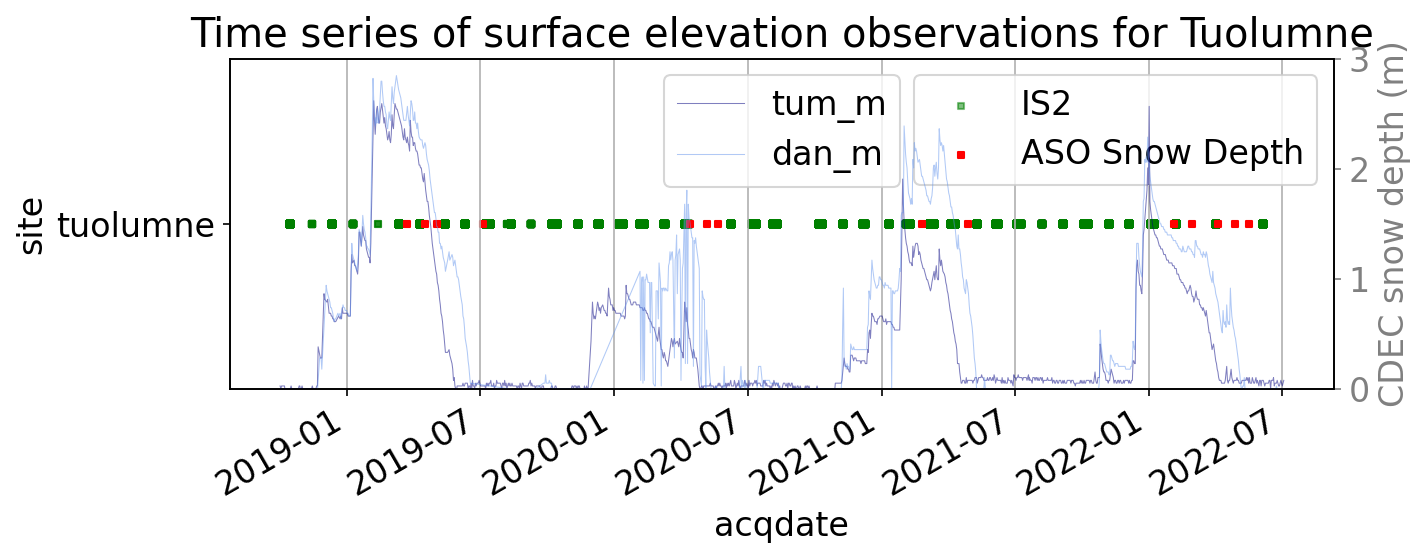

In [211]:
df_list = [aso_gdf, atl06sr_gdf]

f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()
plt.savefig('../../figures/timeseries.jpeg')

## Create this table for all ATL06SR Data

In [466]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus'].count()
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['tum_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['dan_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_m']
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-dan_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-dan_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] / comp_table_all.loc[comp_table_all.index==date,'dan_depth']) * 100
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-tum_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-tum_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] / comp_table_all.loc[comp_table_all.index==date,'tum_depth']) * 100
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'cdec_mean'] = (comp_table_all.loc[comp_table_all.index==date,'tum_depth'] + comp_table_all.loc[comp_table_all.index==date,'dan_depth']) / 2
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-cdec_mean'] = ((comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) / comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) * 100
    
    return comp_table_all

In [467]:
comp_df = make_comparison_table(atl06sr_gdf)

In [450]:
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


In [468]:
comp_tumradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

In [469]:
comp_danradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

In [543]:
comp_tumradius.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean
2018-11-13,2018-11-13,-0.276287,0.459613,3,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653
2019-04-10,2019-04-10,2.318431,1.338913,1284,2.032,NaN,NaN,NaN,0.286431,14.096022,NaN,NaN
2019-05-14,2019-05-14,1.065948,1.075131,925,0.4064,1.143,-0.077052,-6.741188,0.659548,162.29041,0.7747,37.594969
2019-07-09,2019-07-09,0.08624,0.743908,124,0.0,NaN,NaN,NaN,0.08624,inf,NaN,NaN
2019-12-11,2019-12-11,0.412816,0.654866,131,0.7112,NaN,NaN,NaN,-0.298384,-41.955071,NaN,NaN


In [544]:
comp_tumradius = comp_tumradius.drop(columns=['dan_depth', 'atl06-dan_diff', 'atl06-dan_percent'])

In [545]:
comp_danradius = comp_danradius.drop(columns=['tum_depth', 'atl06-tum_diff', 'atl06-tum_percent'])

In [547]:
comp_tumradius.to_csv('../../figures/comp_tumradius.csv')
comp_danradius.to_csv('../../figures/comp_danradius.csv')

In [549]:
np.nanmin(comp_tumradius['atl06-tum_diff'].abs())

0.031130225068332518

In [550]:
np.nanmax(comp_tumradius['atl06-tum_diff'].abs())

0.6595482265384668

In [551]:
np.nanmedian(comp_tumradius['atl06-tum_diff'].abs())

0.16764758616764153

In [552]:
np.nanmedian(comp_tumradius['atl06-tum_percent'].abs())

74.63142371244692

In [553]:
np.nanmin(comp_tumradius['atl06-tum_percent'].abs())

1.9149990814673057

In [554]:
np.nanmax(comp_tumradius['atl06-tum_percent'].abs())

inf

<AxesSubplot: >

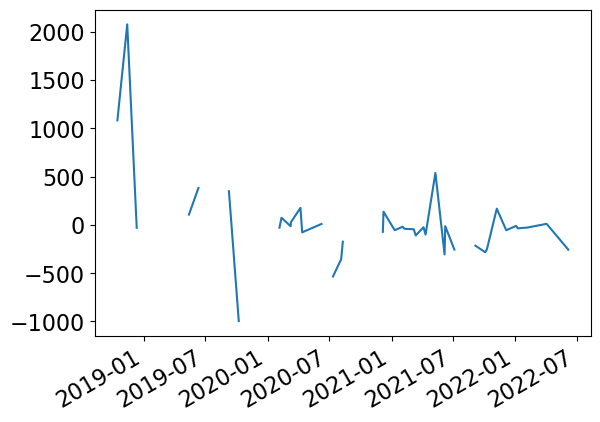

In [464]:
comp_df['atl06-cdec_mean'].plot()

<AxesSubplot: >

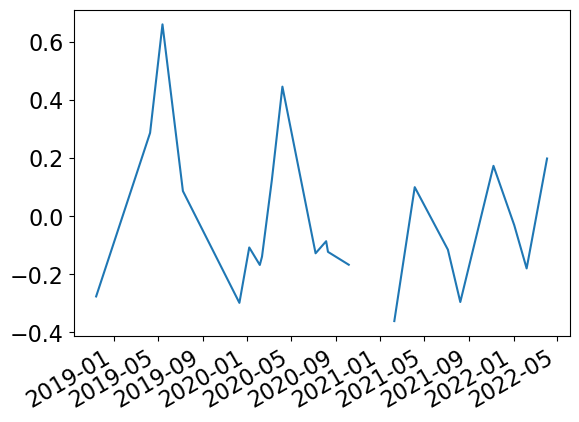

In [470]:
comp_tumradius['atl06-tum_diff'].plot()

<AxesSubplot: >

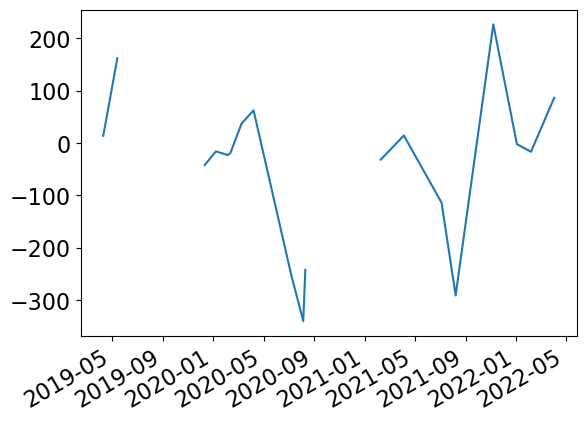

In [471]:
comp_tumradius['atl06-tum_percent'].plot()

<AxesSubplot: >

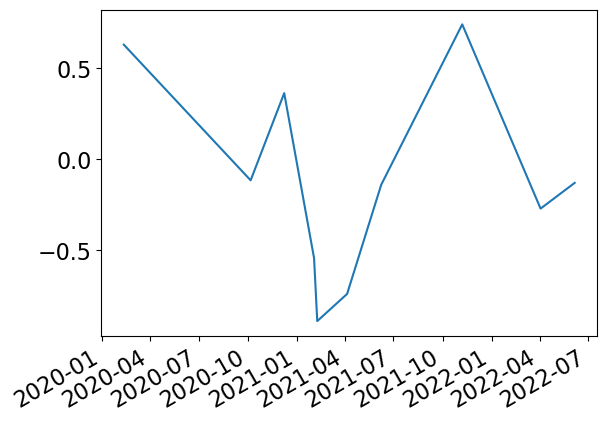

In [460]:
comp_df_danradius['atl06-dan_diff'].plot()

In [465]:
comp_df_tumradius.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-tum_diff,cdec_mean,atl06-cdec_mean
2018-11-13,2018-11-13,-0.276287,0.459613,3,0.0,-0.0254,-0.250887,-0.276287,-0.0127,2075.489653
2019-04-10,2019-04-10,2.318431,1.338913,1284,2.032,NaN,NaN,0.286431,NaN,NaN
2019-05-14,2019-05-14,1.065948,1.075131,925,0.4064,1.143,-0.077052,0.659548,0.7747,37.594969
2019-07-09,2019-07-09,0.08624,0.743908,124,0.0,NaN,NaN,0.08624,NaN,NaN
2019-12-11,2019-12-11,0.412816,0.654866,131,0.7112,NaN,NaN,-0.298384,NaN,NaN


ValueError: x and y must be the same size

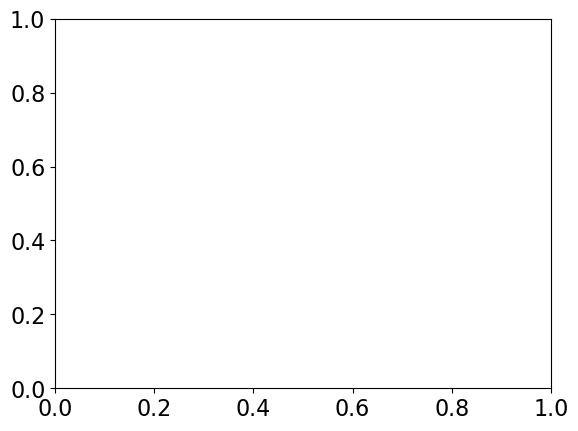

In [456]:
fig, ax = plt.subplots()
plt.scatter(comp_df_danradius['atl06-dan_diff'], comp_df_tumradius['atl06-tum_diff'])
#plt.hlines(y=0, xmin=-50, xmax=7000, color='k')
plt.xlabel('')
plt.ylabel('difference between \nATL06SR and CDEC')

In [447]:
comp_df

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-tum_diff,cdec_mean,atl06-cdec_mean
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,-0.150095,-0.0127,1081.852888
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,-0.276287,-0.0127,2075.489653
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-0.182409,0.6858,-30.301713
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,NaN,NaN,NaN
2019-03-12,2019-03-12,2.825406,2.909036,5937,2.4892,2.7178,0.107606,0.336206,2.6035,8.523365
2019-04-10,2019-04-10,2.452357,1.248204,2393,2.032,NaN,NaN,0.420357,NaN,NaN
2019-05-14,2019-05-14,1.596169,1.778233,4090,0.4064,1.143,0.453169,1.189769,0.7747,106.037019
2019-06-11,2019-06-11,1.222026,1.717712,502,0.0508,0.4572,0.764826,1.171226,0.254,381.112558
2019-07-09,2019-07-09,0.08624,0.644352,388,0.0,NaN,NaN,0.08624,NaN,NaN


In [316]:
comp_table_all = pd.DataFrame()
comp_table_all.index = pd.DatetimeIndex(data=atl06sr_gdf['acqdate'].unique())
comp_table_all['acqdate'] = comp_table_all.index.date

In [318]:
comp_table_all['median'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])

In [319]:
comp_table_all['iqr'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date,'diff_plus'])

In [320]:
comp_table_all['n'] = ''
for date in comp_table_all['acqdate']:
    comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = atl06sr_gdf.loc[atl06sr_gdf['acqdate']==date, 'diff_plus'].count()

In [321]:
comp_table_all['tum_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']

In [322]:
comp_table_all['dan_depth'] = ''
# median depth on that day at the tuolumne meadows cdec pillow
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_m']

In [323]:
comp_table_all['atl06-dan_diff'] = ''
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']

In [324]:
comp_table_all['atl06-tum_diff'] = ''
for date in comp_table_all.index:
    comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']

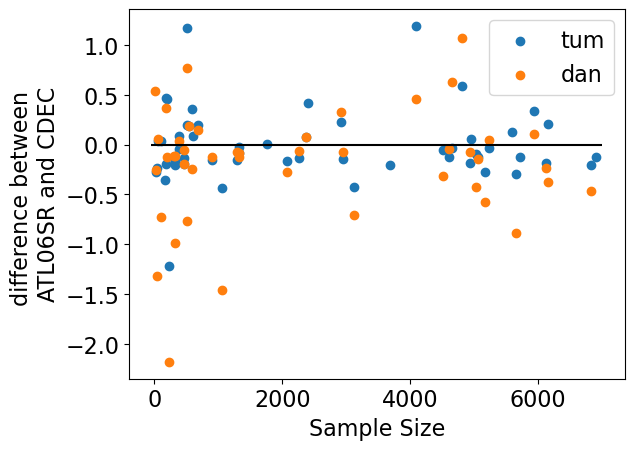

In [325]:
fig, ax = plt.subplots()
plt.scatter(comp_table_all['n'], comp_table_all['atl06-tum_diff'], label='tum')
plt.scatter(comp_table_all['n'], comp_table_all['atl06-dan_diff'], label='dan')
plt.hlines(y=0, xmin=-50, xmax=7000, color='k')
plt.xlabel('Sample Size')
plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


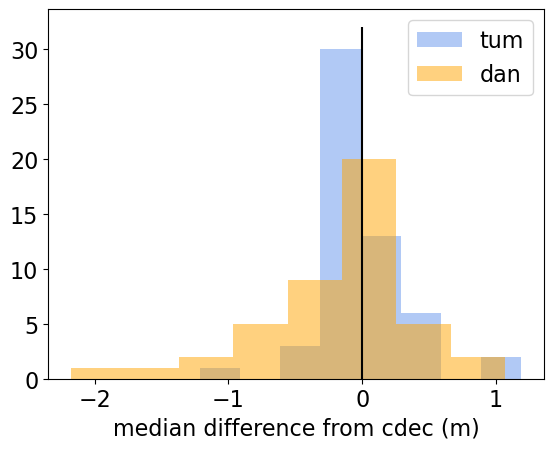

In [326]:
fig, ax = plt.subplots()
plt.hist(comp_table_all['atl06-tum_diff'], bins=round(np.sqrt(len(comp_table_all))), label='tum', alpha=0.5, color='cornflowerblue')
plt.hist(comp_table_all['atl06-dan_diff'], bins=round(np.sqrt(len(comp_table_all))), label='dan', alpha=0.5, color='orange')
plt.vlines(x=0, ymin=0, ymax=32, color='k')
plt.xlabel('median difference from cdec (m)')
#plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

In [181]:
print('Median of the median differences between ATL06SR and DAN:', np.nanmedian(comp_table_all['atl06-dan_diff']))
print('Median of the median differences between ATL06SR and TUM:', np.nanmedian(comp_table_all['atl06-tum_diff']))

Median of the median differences between ATL06SR and DAN: -0.11778255058343248
Median of the median differences between ATL06SR and TUM: -0.09398747191903567


Text(0, 0.5, 'difference between \nATL06SR and TUM CDEC')

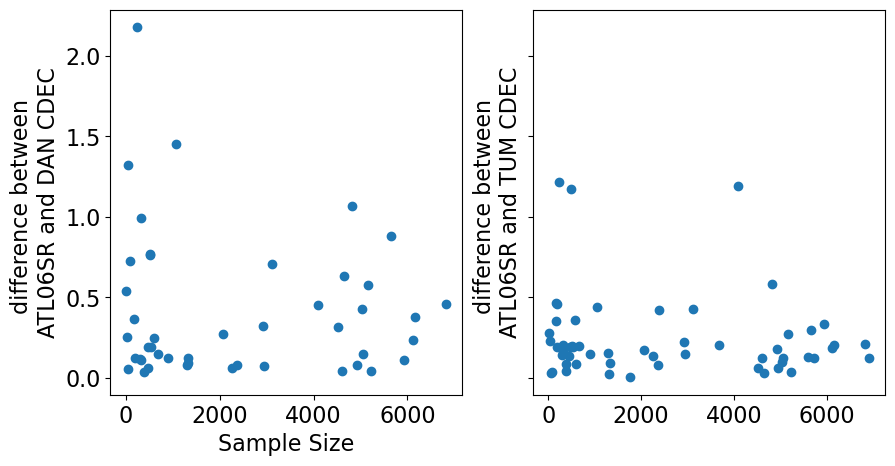

In [330]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table_all['n'], comp_table_all['atl06-dan_diff'].abs())
ax[1].scatter(comp_table_all['n'], comp_table_all['atl06-tum_diff'].abs())
ax[0].set_xlabel('Sample Size')
ax[0].set_ylabel('difference between \nATL06SR and DAN CDEC')
ax[1].set_ylabel('difference between \nATL06SR and TUM CDEC')

## Old, less universal plotting functions:

In [157]:
# # Function adapted from David Shean by Hannah Besso
# # Uses boxplot transparency to indicate sample size

# def boxplot_date_alpha(df, col, groupby_col='acqdate', clim=(-5, 5), title = 'ATL06sr - ASO', name='../Figures/boxplots_cdec.jpeg'):
#     bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
#     bp_stats_list = [i[0] for i in bp_stats.values]
#     bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
#     bp_alpha_boxes = bp_alpha/bp_alpha.max()
#     pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
#     f, ax = plt.subplots(figsize=(20,10))
#     bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, 
#                    whiskerprops={'lw':0.5, 'alpha':0.2}, medianprops={'lw':3}, 
#                    widths=10, patch_artist=True)
    
#     #set the alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
#     for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#     for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
#         patch.set_alpha(alpha)
#         patch.set_color('white')  # or deeppink
#     #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
#     for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
#         patch.set_alpha(alpha)
    
#     #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
#     snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
#     snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
#     ax.axhline(0, color='k', lw=0.5)
#     ax.set_ylabel('Difference Values (m)')
#     ax.set_ylim(*clim)
#     ax.set_xlim([dt_min_plot, dt_max_plot])
#     #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.legend(loc='lower right', title='CDEC Snow Depth')
#     ax.set_title(title)
    
#     #ax.xaxis.set_major_locator(MulitpleLocator(6))
#     years = mdates.YearLocator(month=10)
#     years_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_locator(years)
#     ax.xaxis.set_major_formatter(years_fmt)

#     april = mdates.MonthLocator()
#     months_fmt = mdates.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_minor_locator(april)
#     #ax.xaxis.set_minor_formatter(months_fmt)
#     #ax.tick_params(axis="x", which="both", rotation=35, right=True)
#     #ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    
#     plt.tight_layout()
#     #plt.savefig(name, dpi=500)

In [158]:
def boxplot_date_aso(df, col, col_aso, groupby_col='acqdate', groupby_col_aso='ASO_snowon_date', 
                     clim=(-5, 5), title = 'Difference (ATL06sr - ASO)', name='../figures/boxplots_cdec_aso.jpeg'):
    # ATL06 stats
    bp_stats = df[[col, groupby_col]].dropna().groupby(groupby_col).apply(cbook.boxplot_stats)
    bp_stats_list = [i[0] for i in bp_stats.values]
    bp_alpha = df[[col, groupby_col]].dropna().groupby(groupby_col).count().values.ravel()
    bp_alpha_boxes = bp_alpha/bp_alpha.max()
    pos = (pd.to_datetime(bp_stats.index) - pd.to_datetime(mpl_epoch)).days.values
    
    # ASO Snow-On Stats
    bp_stats2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).apply(cbook.boxplot_stats)
    bp_stats_list2 = [i[0] for i in bp_stats2.values]
    bp_alpha2 = df[[col_aso, groupby_col_aso]].dropna().groupby(groupby_col_aso).count().values.ravel()
    bp_alpha_boxes2 = bp_alpha2/bp_alpha2.max()
    pos2 = (pd.to_datetime(bp_stats2.index) - pd.to_datetime(mpl_epoch)).days.values    
    
    f, ax = plt.subplots(figsize=(20,10))
    
    #snwd[['tum_m', 'dan_m']].plot(ax=ax, lw=2, style=['--','-'])
    snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.6, color='darkorange', lw=2, label='Tuolumne Meadows')
    snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.6, color='lightpink', lw=2, label='Dana Meadows')
    
    # Plot ATL06 data
    bxp_f = ax.bxp(bp_stats_list, positions=pos, showfliers=False, showcaps=False, patch_artist=True,
                   whiskerprops={'lw':0.5, 'alpha':0.2}, boxprops= {'lw':1},  
                   medianprops={'lw':3}, widths=10)
    # Plot ASO snow on data
    bxp_f2 = ax.bxp(bp_stats_list2, positions=pos2, showfliers=False, showcaps=False, patch_artist=True,
                    whiskerprops={'lw':0.5, 'alpha':0.2, 'c':'orange'}, boxprops= {'lw':1}, 
                    medianprops={'lw':3}, widths=10)

    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_color('mediumvioletred')
    # https://stackoverflow.com/questions/47528955/adding-a-legend-to-a-matplotlib-boxplot-with-multiple-plots-on-same-axes
    # https://stackoverflow.com/questions/12761806/matplotlib-2-different-legends-on-same-graph
    legend1 = ax.legend(loc='upper right', title='CDEC Snow Depth')
    legend2 = ax.legend([bxp_f["boxes"][0], bxp_f2["boxes"][0]], ['ATL06SR', 'ASO Tracks'], loc='upper left', title='Boxplots')
    #legend2.set_alpha(1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)  
    
    #set the ATL06SR alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f['boxes'], bp_alpha_boxes):
        patch.set_alpha(alpha)
    for patch, alpha in zip(bxp_f['medians'], bp_alpha_boxes):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f['whiskers'], [item for sublist in zip(bp_alpha_boxes, bp_alpha_boxes) for item in sublist]):
        patch.set_alpha(alpha)
        
    #set the ASO Snow On alpha (transparency) for each box, whisker, and median according to the number of samples for that measurement
    for patch, alpha in zip(bxp_f2['boxes'], bp_alpha_boxes2):
        patch.set_alpha(alpha)    
    for patch, alpha in zip(bxp_f2['medians'], bp_alpha_boxes2):
        patch.set_alpha(alpha)
        patch.set_color('white')  # or deeppink
    #double the alpha list since there are 2 whiskers per box (https://datagy.io/python-combine-lists/)
    for patch, alpha in zip(bxp_f2['whiskers'], [item for sublist in zip(bp_alpha_boxes2, bp_alpha_boxes2) for item in sublist]):
        patch.set_alpha(alpha)   
    
    ax.axhline(0, color='k', lw=0.5)
    ax.set_ylabel('Difference Values (m)')
    ax.set_ylim(*clim)
    ax.set_xlim([dt_min_plot, dt_max_plot])
    ax.set_title(title)
    
    years = mdates.YearLocator(month=10)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    years_fmt = mdates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    months = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(months)
    
    plt.tight_layout()
    #plt.savefig(name, dpi=500)